In [1]:
import pandas as pd
import numpy as np

# Libraries for plotting graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Library for saving and loading trained models
import joblib
import json

# Libraries for resampling and Label encoding
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# Libraries for model building and player embedding
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Embedding, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


In [2]:
def preprocess_dataset_by_year(year):
    # choose any n consecutive datasets
    n = 3
    df = None
    for i in range(n):
        year_i = year - i
        if year_i >= 2015:
            year = 2015
        if year_i <= 2007:
            year_i = 2007
            dataset_year = pd.read_csv("datasets/matchups-" + str(year_i) + ".csv")
            df = pd.concat([dataset_year, df])
            break
        dataset_year = pd.read_csv("datasets/matchups-" + str(year_i) + ".csv")
        df = pd.concat([dataset_year, df])

    return df


# Data preprocessing

Checking class imbalance

In [4]:
def handle_class_imbalance(df):
    class_distribution = df['outcome'].value_counts().to_dict()

    # Ploting the class imbalance to analyse the target variable.
    sns.countplot(x='outcome', data=df)
    plt.title('Class Imbalance')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

    print(class_distribution[-1], " ", class_distribution[1])
    # Separating the minority and majority class samples.
    major_class = 1 if class_distribution[1] > class_distribution[-1] else -1
    minor_class = -1 * major_class
    df_majority = df[df.outcome == major_class]
    df_minority = df[df.outcome == minor_class]

    # Upsampling minority class
    df_minority_upsampled = resample(df_minority,
                                    replace=True,  # sampling with replacement
                                    n_samples=len(df_majority),  # matching majority n
                                    random_state=42)  # reproducible results
    df=pd.concat([df_majority, df_minority_upsampled]) #Redefining the dataframe with the upsampled data
    df = df.reset_index(drop = True)

    # Checking the imbalance of the class again.
    class_distribution = df['outcome'].value_counts()
    print(class_distribution)

    # Ploting class imbalance
    sns.countplot(x='outcome', data=df)
    plt.title('Class Imbalance')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

    return df


# Data Transformation

Now encoding the player names since the machine doesnt undertand the textual data.

In [49]:
def get_players_list_by_season_and_team(df):
    players_list_by_team = {}
    for i in range(df.shape[0]):
        season = int(df.loc[i, 'season'])
        home_team = df.loc[i, 'home_team']
        away_team = df.loc[i, 'away_team']
        if season not in players_list_by_team:
            players_list_by_team[season] = {}
        if home_team not in players_list_by_team[season]:
            players_list_by_team[season][home_team] = set()
        if away_team not in players_list_by_team[season]:
            players_list_by_team[season][away_team] = set()
        for j in range(5):
            players_list_by_team[season][home_team].add(df.loc[i, 'home_' + str(j)])
            players_list_by_team[season][away_team].add(df.loc[i, 'away_' + str(j)])
    for year in players_list_by_team:
        for teams in players_list_by_team[year]:
            players_list_by_team[year][teams] = list(players_list_by_team[year][teams])
    return players_list_by_team

In [7]:
def player_name_encoding(df):
    # Here we are abstracting all the unique home players from all the home columns.
    player_columns = ['home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

    # Combining all the players
    all_players = df[player_columns].values.flatten()

    # Initializing and fitting the label encoder
    encoder = LabelEncoder()
    encoder.fit(all_players)

    # Encoding player names in the dataset
    for col in player_columns:
        df.loc[:, col] = encoder.transform(df[col])
    
    # Get the mapping of player names to numbers
    player_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

    for players in player_name_mapping:
        player_name_mapping[players] = int(player_name_mapping[players])

    return df, player_name_mapping

# Feature Engineering

Based on the research conducted on how to understand the NBA game and statistics, there were four main factors that will decide if a team wins and losses. They encompass the important statistics of the team’s performance which are defined by the following four factors.
The factor formulas are:
•	Shooting the ball
Effective Field Goal Percentage= (Field Goals Made) + 0.5*3P Field Goals Made))/(Field Goal Attempts)
•	Taking care of the ball
Turnover Rate=Turnovers/ (Field Goal Attempts + 0.44*Free Throw Attempts + Turnovers)
•	Offensive rebounding
Offensive Rebounding Percentage = (Offensive Rebounds)/ [(Offensive Rebounds) +(Opponent’s Defensive Rebounds)]
•	Getting to the foul line
Free Throw Rate= (Free Throws Made)/(Field Goals Attempted) or Free Throws Attempted/Field Goals Attempted

Thus utilizing the data available to calculate the above factors for home and away lineups.

In [11]:
def feature_engineering(df):
    # Step 1: Identify useful features
    # Converting class labels from -1 to 0 and 1 to 1
    df['outcome']=(df['outcome']+1)/2

    # Field Goal Percentage
    df['fg_pct_home'] = df['fgm_home'] / df['fga_home'].replace(0, np.nan)

    # Three-Point Percentage
    df['3p_pct_home'] = df['fgm_3_home'] / df['fga_3_home'].replace(0, np.nan)

    # Free Throws Made & Percentage
    df['ftm_home'] = df['pts_home'] - (2 * df['fgm_2_home'] + 3 * df['fgm_3_home'])
    df['ft_pct_home'] = df['ftm_home'] / df['fta_home'].replace(0, np.nan)

    # True Shooting Percentage
    df['ts_pct_home'] = df['pts_home'] / (2 * (df['fga_home'] + 0.44 * df['fta_home'])).replace(0, np.nan)

    # Assist-to-Turnover Ratio
    df['ast_to_ratio_home'] = df['ast_home'] / df['to_home'].replace(0, np.nan)

    # Rebound Rates
    df['off_reb_rate_home'] = df['oreb_home'] / df['reb_home'].replace(0, np.nan)
    df['def_reb_rate_home'] = df['dreb_home'] / df['reb_home'].replace(0, np.nan)

    # Field Goal Percentage
    df['fg_pct_visitor'] = df['fgm_visitor'] / df['fga_visitor'].replace(0, np.nan)

    # Three-Point Percentage
    df['3p_pct_visitor'] = df['fgm_3_visitor'] / df['fga_3_visitor'].replace(0, np.nan)

    # Free Throws Made & Percentage
    df['ftm_visitor'] = df['pts_visitor'] - (2 * df['fgm_2_visitor'] + 3 * df['fgm_3_visitor'])
    df['ft_pct_visitor'] = df['ftm_visitor'] / df['fta_visitor'].replace(0, np.nan)

    # True Shooting Percentage
    df['ts_pct_visitor'] = df['pts_visitor'] / (2 * (df['fga_visitor'] + 0.44 * df['fta_visitor'])).replace(0, np.nan)

    # Assist-to-Turnover Ratio
    df['ast_to_ratio_visitor'] = df['ast_visitor'] / df['to_visitor'].replace(0, np.nan)

    # Rebound Rates
    df['off_reb_rate_visitor'] = df['oreb_visitor'] / df['reb_visitor'].replace(0, np.nan)
    df['def_reb_rate_visitor'] = df['dreb_visitor'] / df['reb_visitor'].replace(0, np.nan)

    # Dropping the unncessary columns
    df.drop(['game', 'starting_min', 'end_min',
        'fga_home', 'fta_home', 'fgm_home',
        'fga_2_home', 'fgm_2_home', 'fga_3_home', 'fgm_3_home', 'ast_home',
        'blk_home', 'pf_home', 'reb_home', 'dreb_home', 'oreb_home', 'to_home',
        'fga_visitor', 'fta_visitor', 'fgm_visitor', 'fga_2_visitor', 'fgm_2_visitor',
        'fga_3_visitor', 'fgm_3_visitor', 'ast_visitor', 'blk_visitor',
        'pf_visitor', 'reb_visitor', 'dreb_visitor', 'oreb_visitor',
        'to_visitor'],inplace=True,axis=1)
    
    # Analysing the percentage of null values in the columns.
    null_counts = df.isnull().sum()

    # Calculating the total number of rows in the DataFrame
    total_rows = len(df)

    # Calculating the percentage of null values for each column
    null_percentage = (null_counts / total_rows) * 100

    print("Percentage of null values for each column:")
    print(null_percentage)

    # Here the percentage of null values is quite low which can be replaced by the 0.
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)

    # Analysing the percentage of null values in the columns.
    null_counts = df.isnull().sum()

    # Calculating the percentage of null values for each column
    null_percentage = (null_counts / total_rows) * 100

    print("Percentage of null values for each column:")
    print(null_percentage)

    # Creating a box plot to check for the outliers.

    sns.boxplot(data=df[['outcome', 'fg_pct_home', '3p_pct_home',
                         'ftm_home', 'ft_pct_home', 'ts_pct_home',
                         'ast_to_ratio_home', 'off_reb_rate_home',
                         'def_reb_rate_home', 'fg_pct_visitor',
                         '3p_pct_visitor', 'ftm_visitor', 'ft_pct_visitor',
                         'ts_pct_visitor', 'ast_to_ratio_visitor',
                         'off_reb_rate_visitor', 'def_reb_rate_visitor']]).set(title='A plot to check for outliers')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Creating a new column by concatenating home players and forming an array representing the home lineup.
    df['home_lineup'] = df.apply(lambda row: (row['home_0'], row['home_1'], row['home_2'], row['home_3'], row['home_4']), axis=1)

    # Creating a new column by concatenating away players and forming an array representing the away lineup.
    df['away_lineup'] = df.apply(lambda row: (row['away_0'], row['away_1'], row['away_2'], row['away_3'], row['away_4']), axis=1)

    return df


# Model for generating embeddings

Tranforming the data to make it ready for the model to generate embeddings

In [12]:
def data_transformation(df):
    # Stacking the arrays along axis=1 to make them understandable by neural network.
    array = np.stack(df['home_lineup'])
    home_array = [', '.join(map(str, row)) for row in array]

    # Defining the home lineups in X_home which will then be used to generate embeddings for each home player.
    X_home= [[int(x) for x in row.split(', ')] for row in home_array]
    X_home = np.array(X_home)

    array = np.stack(df['away_lineup'])
    away_array = [', '.join(map(str, row)) for row in array]

    # Defining the away lineups in X_away which will then be used to generate embeddings for each away player.
    X_away= [[int(x) for x in row.split(', ')] for row in away_array]
    X_away = np.array(X_away)

    # Defining the target variable which is the outcome of the game.
    y=df['outcome']

    # Defining the statistics for home and away lineups in X_stats.
    X_stats=df[['fg_pct_home','3p_pct_home',
                'ftm_home', 'ft_pct_home',
                'ts_pct_home', 'ast_to_ratio_home',
                'off_reb_rate_home', 'def_reb_rate_home',
                'fg_pct_visitor', '3p_pct_visitor',
                'ftm_visitor', 'ft_pct_visitor',
                'ts_pct_visitor', 'ast_to_ratio_visitor',
                'off_reb_rate_visitor', 'def_reb_rate_visitor']]

    return X_home, X_away, X_stats, y


Generate Player Embeddings using transformed data

In [13]:
def generate_player_embedding(X_home, X_away, X_stats, y, player_name_mappings):
    num_stats=X_stats.shape[1] # We have eight stats for home and eight stats for away teams.

    home_player_comb_input = Input(shape=(5,)) # Since the combinations are of 5 players.
    away_player_comb_input = Input(shape=(5,))
    stats_input = Input(shape=(num_stats,))  # Assuming num_stats is the number of stats per combination.

    # Adding the embedding layer for home player combinations
    home_player_embedding_layer = Embedding(input_dim=len(player_name_mappings), output_dim=32, name='home_embedding')(home_player_comb_input)
    flattened_home_player_embedding = Flatten()(home_player_embedding_layer)

    # Adding embedding layer for away player combinations.
    away_player_embedding_layer = Embedding(input_dim=len(player_name_mappings), output_dim=32, name='away_embedding')(away_player_comb_input)
    flattened_away_player_embedding = Flatten()(away_player_embedding_layer)

    # Concatenating the flattened player embeddings with stats input.
    concatenated_features = Concatenate()([flattened_home_player_embedding, flattened_away_player_embedding, stats_input])

    # Adding dense layers for further processing.
    hidden_layer = Dense(32, activation='relu')(concatenated_features)

    output_layer = Dense(1, activation='sigmoid')(hidden_layer)

    # Defining the model
    model = Model(inputs=[home_player_comb_input, away_player_comb_input, stats_input], outputs=output_layer)

    # Defining the initial learning rate.
    initial_learning_rate = 0.001
    opt = Adam(learning_rate=initial_learning_rate)

    # Defining loss function as binary_crossentropy sice the target variable is binary.
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Define learning rate scheduler to automatically change the learning rate by monitoring the validation loss.
    change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

    # Defining early stopping criteria in order to avoid overfitting.
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Printing model summary
    model.summary()

    # Training the model with learning rate schedule.
    home_history = model.fit([X_home, X_away, X_stats], y, epochs=50, batch_size=32, validation_split=0.2,callbacks=[change_lr, early_stop])

    return model

In [14]:
def map_player_embedding(df, model):
    # Storing the weights which are the 32-dimensional feature vectors for the home players in the dictionary.
    home_weights=model.get_layer('home_embedding').get_weights()[0]
    home_player_weights = {index: array for index, array in enumerate(home_weights)}
    
    # Storing the weights which are the 32-dimensional feature vectors for the away players in the dictionary.
    away_weights=model.get_layer('away_embedding').get_weights()[0]
    # Using dictionary comprehension
    away_player_weights = {index: array for index, array in enumerate(away_weights)}

    # Mapping these 32 dimensional vectors in the datframe.
    for col in ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']:
        df[col] = df[col].map(home_player_weights)

    for col in ['away_0', 'away_1', 'away_2', 'away_3', 'away_4']:
        df[col] = df[col].map(away_player_weights)

    # Preparing the X and y variables for our final classification model to classify embeddings as win or loss.
    X = df[['home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4']].values
    y = df['outcome'].values
    X_flat = np.vstack([np.concatenate(arr) for arr in X])

    return X_flat, y


# Model Building for classifying the embeddings.

# Logistic regression

In [15]:
def split_lr_train_test_data(X, y):
    # Splitting data into training and testing sets.
    # X_train, X_test, y_train, y_test =
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train logistic regression model
def train_test_logistic_regression(X, y):
    # Defining the logistic regression model.
    lr_model = LogisticRegression(max_iter=10000)

    lr_model.fit(X, y)

    return lr_model


In [16]:
# Function to predict results using logistic regression model
def predict_logistic_regression(model, X):
    # Making predictions
    return model.predict(X)


In [17]:
def generate_classification_report(y_test, y_pred):
    # Calculating and printing classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


In [18]:
# Plot model results
def plot_logistic_regression_model_diagnostics(model, X_test, y_test):
    """Create three-panel diagnostic plot for classification models"""
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig


# SVM

In [19]:
def split_svm_train_test_data(X, y):
    # Scale the features - crucial for SVM performance
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Split the scaled data
    # X_train, X_test, y_train, y_test = 
    return train_test_split(
        X_flat_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y  # Ensure balanced split
    )

def train_support_vector_machines(X, y):
    # Create optimized LinearSVC model
    svm_model = LinearSVC(
        dual='auto',          # Let sklearn choose the best solver
        C=1.0,               # Regularization parameter
        max_iter=2000,       # Increase max iterations for convergence
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        tol=1e-4            # Tolerance for stopping criterion
    )

    # Train the model
    print("Training model...")
    svm_model.fit(X, y)

    return svm_model

def predict_svm(svm_model, X):
    # Make predictions
    print("Making predictions...")
    return svm_model.predict(X)

def view_svm_results(svm_model, y_test, y_pred):
    # Print results
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Get feature importances (absolute values of coefficients)
    feature_importance = np.abs(svm_model.coef_[0])
    top_features = np.argsort(feature_importance)[-5:]  # Get top 5 features
    print("\nTop 5 most important features:")
    for idx in reversed(top_features):
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")


In [20]:
def plot_svm_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for SVM model"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and decision scores
    y_pred = model.predict(X_test)
    decision_scores = model.decision_function(X_test)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, decision_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()

    # Print performance summary
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")
    print("\nTop 5 Features:")
    feature_importance = np.abs(model.coef_[0])
    for idx in np.argsort(feature_importance)[-5:][::-1]:
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")
    return fig


# Neural Networks

In [21]:
def split_nn_train_test_data(X, y):
    # Scale the features
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Split the scaled data
    # X_train, X_test, y_train, y_test = 
    return train_test_split(
        X_flat_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

def train_neural_network_model(X_train, X_test, y_train, y_test):
    # Define a more sophisticated model architecture
    model = Sequential([
        # Input layer with batch normalization
        Dense(512, input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers with decreasing neurons
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile with a lower initial learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Enhanced callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=8,
        verbose=1,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Train the model with a larger batch size
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr, early_stop, checkpoint],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    return model

def predict_neural_network_model(model, X_test):
    # Make predictions and calculate metrics
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    return y_pred, y_pred_classes

def evaluate_nn_metrics(y_test, y_pred, y_pred_classes):
    # Calculate detailed metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    print("\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))


In [22]:
def plot_nn_diagnostics(model, X_test, y_test):
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig


# Random Forest

In [23]:
def split_random_forest_train_test_data(X, y):
    # Scale features - this is important but not computationally heavy
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality while preserving 95% of variance
    print("Applying PCA...")
    pca = PCA(n_components=0.95, random_state=42)
    X_flat_reduced = pca.fit_transform(X_flat_scaled)
    print(f"Reduced dimensions from {X_flat_scaled.shape[1]} to {X_flat_reduced.shape[1]} features")

    # Stratified split to handle class imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat_reduced,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler, pca

def train_random_forest_model(X, y):
    # Create a more efficient but improved model
    rf_model = RandomForestClassifier(
        n_estimators=100,        # Moderate number of trees
        max_depth=15,           # Reasonable depth
        min_samples_split=10,   # Balanced value
        min_samples_leaf=4,     # Balanced value
        max_features='sqrt',    # Reduces feature consideration at each split
        n_jobs=2,              # Use only 2 CPU cores to prevent freezing
        class_weight='balanced', # Handle class imbalance
        random_state=42
    )

    # Train the model
    rf_model.fit(X, y)

    return rf_model

def predict_random_forest_model(model, X):
    # Predict and evaluate
    return model.predict(X)

def evaluate_random_forest_model(model, y_test, y_pred):
    # Print results
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Get top 5 feature importances (limited to save memory)
    feature_importance = model.feature_importances_
    top_features = np.argsort(feature_importance)[-5:]
    print("\nTop 5 most important features:")
    for idx in reversed(top_features):
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")
    
    # Calculating and printing classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


In [24]:
def plot_rf_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for Random Forest model"""
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    plt.show()


# KNN

In [25]:
def split_knn_train_test_data(X, y):
    # Scale the features - crucial for distance-based algorithms
    print("Scaling features...")
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality while preserving 95% of variance
    print("Applying PCA...")
    pca = PCA(n_components=0.95, random_state=42)
    X_flat_reduced = pca.fit_transform(X_flat_scaled)
    print(f"Reduced dimensions from {X_flat_scaled.shape[1]} to {X_flat_reduced.shape[1]} features")

    # Split the reduced data
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat_reduced,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler, pca

def train_knn_model(X, y):
    # Create optimized KNN classifier
    knn_classifier = KNeighborsClassifier(
        n_neighbors=5,           # Odd number to avoid ties
        weights='distance',      # Weight points by distance
        metric='cosine',        # Cosine similarity often works well for high-dim data
        n_jobs=2,               # Parallel processing but not too intensive
        leaf_size=30            # Optimal for cosine distance
    )

    # Perform quick cross-validation
    print("\nPerforming cross-validation...")
    cv_scores = cross_val_score(knn_classifier, X, y, cv=3, n_jobs=2)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Train the final model
    print("\nTraining final model...")
    knn_classifier.fit(X, y)

    return knn_classifier

def predict_knn_model(model, X):
    # Make predictions
    return model.predict(X), model.predict_proba(X)

def evaluate_knn_model(model, y_test, y_pred, y_pred_proba):
    # Calculate and print metrics
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print confidence metrics
    print("\nPrediction Confidence Analysis:")
    confidence_scores = np.max(y_pred_proba, axis=1)
    print(f"Mean confidence: {confidence_scores.mean():.3f}")
    print(f"Min confidence: {confidence_scores.min():.3f}")
    print(f"Max confidence: {confidence_scores.max():.3f}")


In [26]:
def plot_knn_diagnostics(model, X_test, y_test):
    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred, y_proba = predict_knn_model(model, X_test)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Win'])
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title('Confusion Matrix', fontsize=14, pad=20)
    ax[0].grid(False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot(ax=ax[1], color='#1f77b4')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc), fontsize=14, pad=20)

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'support'

    # Get the original index labels (class names, 'accuracy', etc.)
    original_labels = report_df.index.tolist()

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f',
            cbar=False, ax=ax[2], annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14, pad=20)

    # Set y-tick labels using the original labels
    ax[2].set_yticklabels(original_labels, rotation=0)

    # Save and display
    plt.show()


Create Datasets based on years

In [27]:
dataset_2015 = preprocess_dataset_by_year(2015)
dataset_2015.shape

(82380, 53)

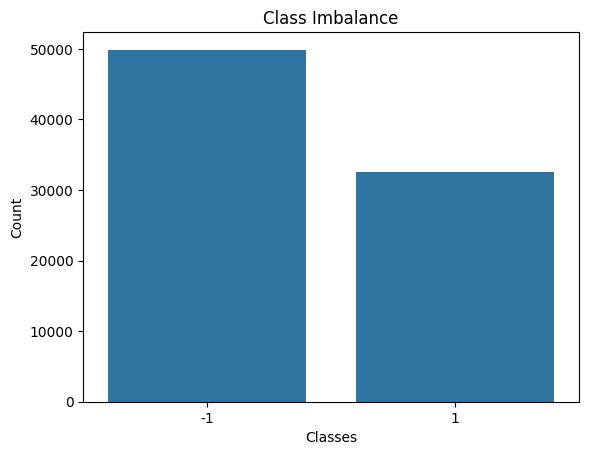

49878   32502
outcome
-1    49878
 1    49878
Name: count, dtype: int64


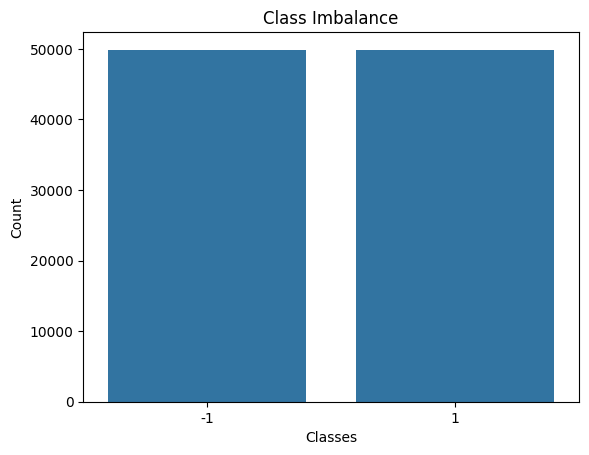

(99756, 53)

In [28]:
dataset_2015 = handle_class_imbalance(dataset_2015)
dataset_2015.shape

In [29]:
dataset_2015, player_name_mapping_2015 = player_name_encoding(dataset_2015)
dataset_2015.shape
player_name_mapping_2015

{'A.J. Price': 0,
 'Aaron Brooks': 1,
 'Aaron Gordon': 2,
 'Aaron Gray': 3,
 'Adonis Thomas': 4,
 'Adreian Payne': 5,
 'Al Harrington': 6,
 'Al Horford': 7,
 'Al Jefferson': 8,
 'Al-Farouq Aminu': 9,
 'Alan Anderson': 10,
 'Alec Burks': 11,
 'Alex Kirk': 12,
 'Alex Len': 13,
 'Alexey Shved': 14,
 'Alexis Ajinca': 15,
 'Allen Crabbe': 16,
 'Alonzo Gee': 17,
 "Amar'e Stoudemire": 18,
 'Amir Johnson': 19,
 'Anderson Varejao': 20,
 'Andray Blatche': 21,
 'Andre Dawkins': 22,
 'Andre Drummond': 23,
 'Andre Iguodala': 24,
 'Andre Miller': 25,
 'Andre Roberson': 26,
 'Andrea Bargnani': 27,
 'Andrei Kirilenko': 28,
 'Andrew Bogut': 29,
 'Andrew Bynum': 30,
 'Andrew Goudelock': 31,
 'Andrew Nicholson': 32,
 'Andrew Wiggins': 33,
 'Andris Biedrins': 34,
 'Antawn Jamison': 35,
 'Anthony Bennett': 36,
 'Anthony Davis': 37,
 'Anthony Morrow': 38,
 'Anthony Randolph': 39,
 'Anthony Tolliver': 40,
 'Archie Goodwin': 41,
 'Arinze Onuaku': 42,
 'Arnett Moultrie': 43,
 'Aron Baynes': 44,
 'Arron Afflalo

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              5.956534
3p_pct_home             44.215887
ftm_home                 0.000000
ft_pct_home             60.499619
ts_pct_home              4.177192
ast_to_ratio_home       58.532820
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

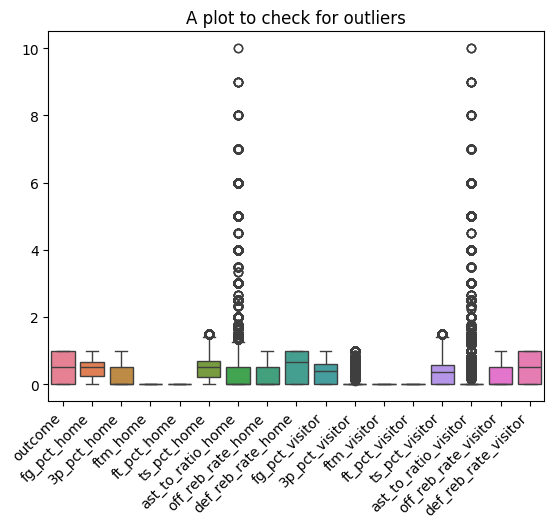

(99756, 40)

In [30]:
dataset_2015 = feature_engineering(dataset_2015)
dataset_2015.shape

In [31]:
X_home_2015, X_away_2015, X_stats_2015, y_2015 = data_transformation(dataset_2015)

In [32]:
embedding_model_2015 = generate_player_embedding(X_home_2015, X_away_2015, X_stats_2015, y_2015, player_name_mapping_2015)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     20,736 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     20,736 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 336)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     10,784 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,289 (204.25 KB)

 Trainable params: 52,289 (204.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8469 - loss: 0.3598 - val_accuracy: 0.8579 - val_loss: 0.2985 - learning_rate: 0.0010
Epoch 2/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9088 - loss: 0.2083 - val_accuracy: 0.8878 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 3/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9313 - loss: 0.1648 - val_accuracy: 0.8970 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 4/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9441 - loss: 0.1376 - val_accuracy: 0.8846 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 5/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9553 - loss: 0.1165 - val_accuracy: 0.9110 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 6/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9627 - loss: 0.1006 - val_accuracy: 0.9195 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 7/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9702 - l

In [33]:
X_2015, y_2015 = map_player_embedding(dataset_2015, embedding_model_2015)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.52      0.54     10059
         1.0       0.55      0.60      0.58      9893

    accuracy                           0.56     19952
   macro avg       0.56      0.56      0.56     19952
weighted avg       0.56      0.56      0.56     19952



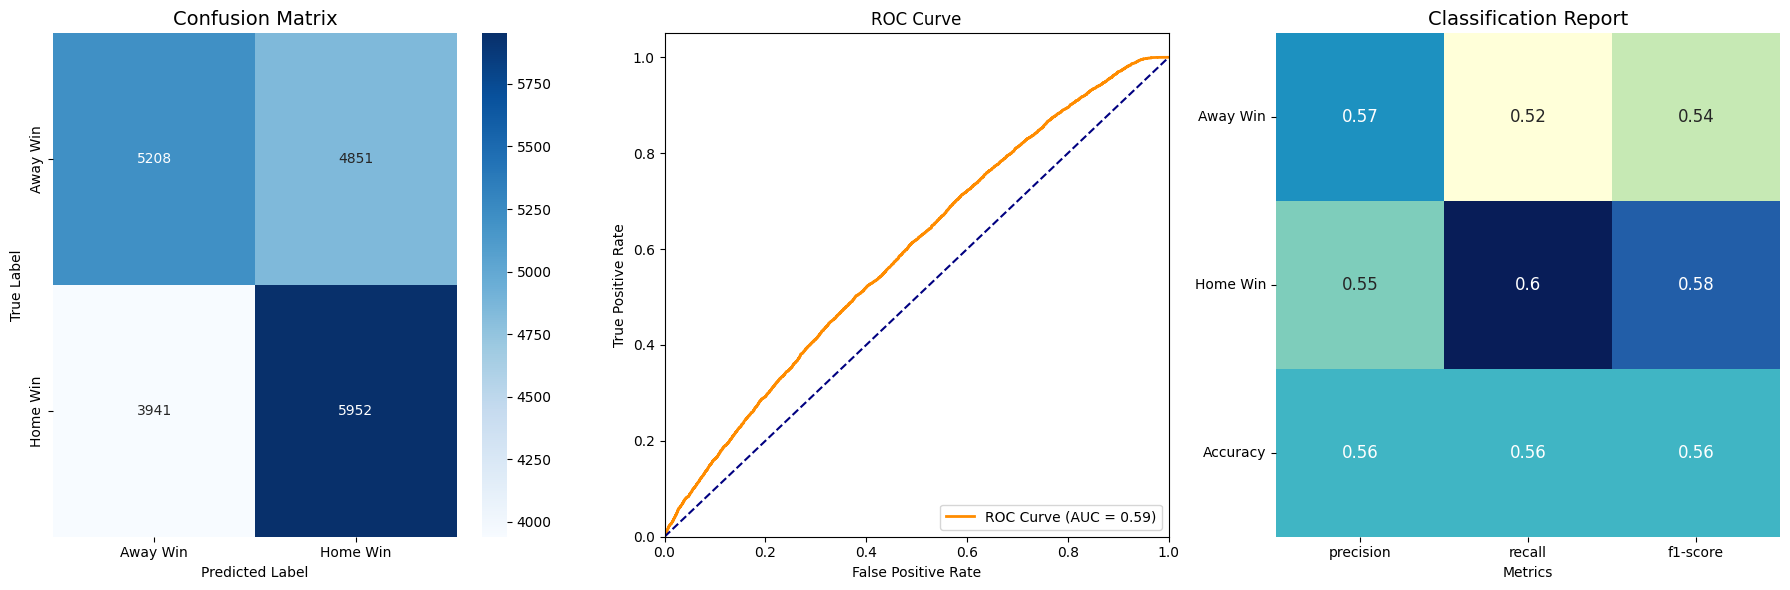

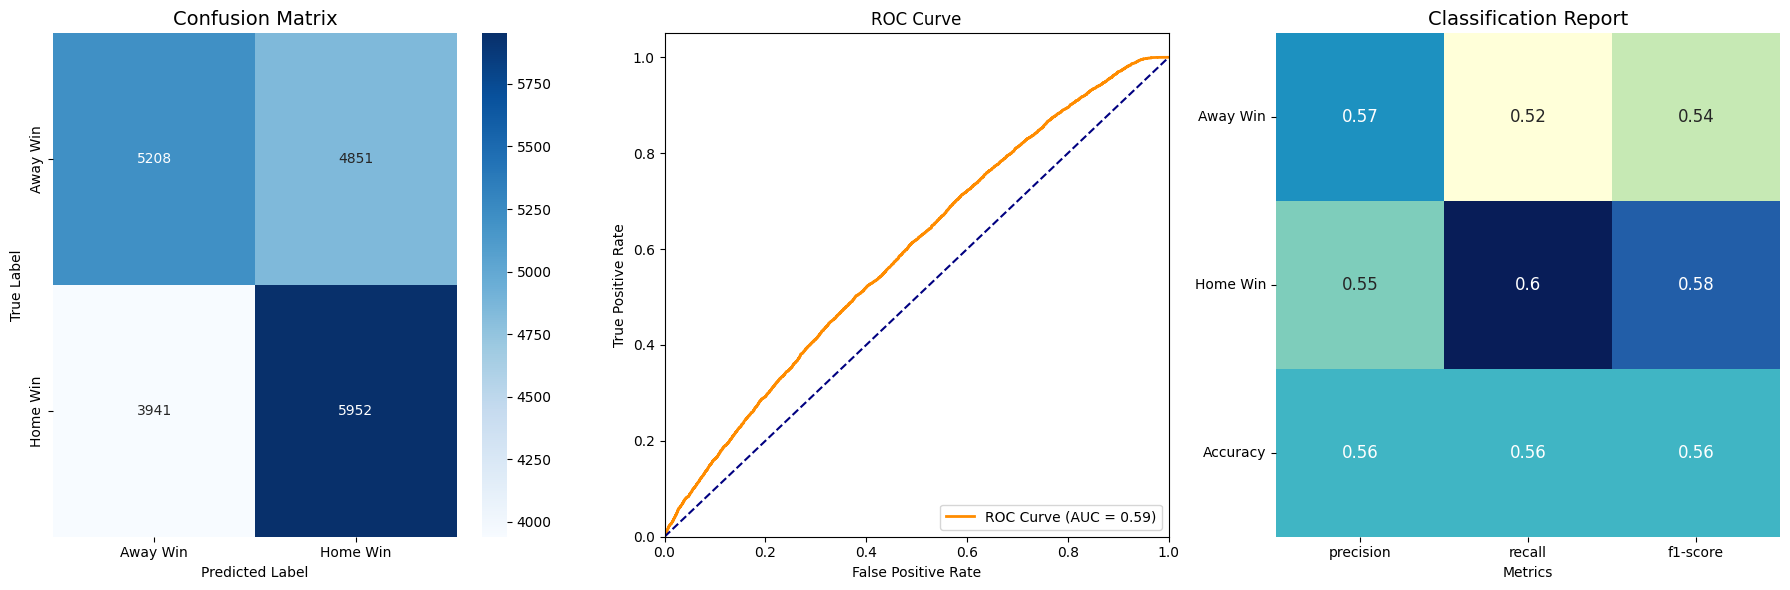

In [34]:
# Logistic Regression
X_train_lr_2015, X_test_lr_2015, y_train_lr_2015, y_test_lr_2015 = split_lr_train_test_data(X_2015, y_2015)
lr_model_2015 = train_test_logistic_regression(X_train_lr_2015, y_train_lr_2015)
y_pred_lr_2015 = predict_logistic_regression(lr_model_2015, X_test_lr_2015)
generate_classification_report(y_test_lr_2015, y_pred_lr_2015)
plot_logistic_regression_model_diagnostics(lr_model_2015, X_test_lr_2015, y_test_lr_2015)


Training model...
Making predictions...

Accuracy: 0.5600441058540497

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.51      0.54      9976
         1.0       0.56      0.61      0.58      9976

    accuracy                           0.56     19952
   macro avg       0.56      0.56      0.56     19952
weighted avg       0.56      0.56      0.56     19952


Top 5 most important features:
Feature 118: 0.0448
Feature 141: 0.0348
Feature 39: 0.0347
Feature 150: 0.0331
Feature 7: 0.0309
Test Accuracy: 0.560

Top 5 Features:
Feature 118: 0.0448
Feature 141: 0.0348
Feature 39: 0.0347
Feature 150: 0.0331
Feature 7: 0.0309


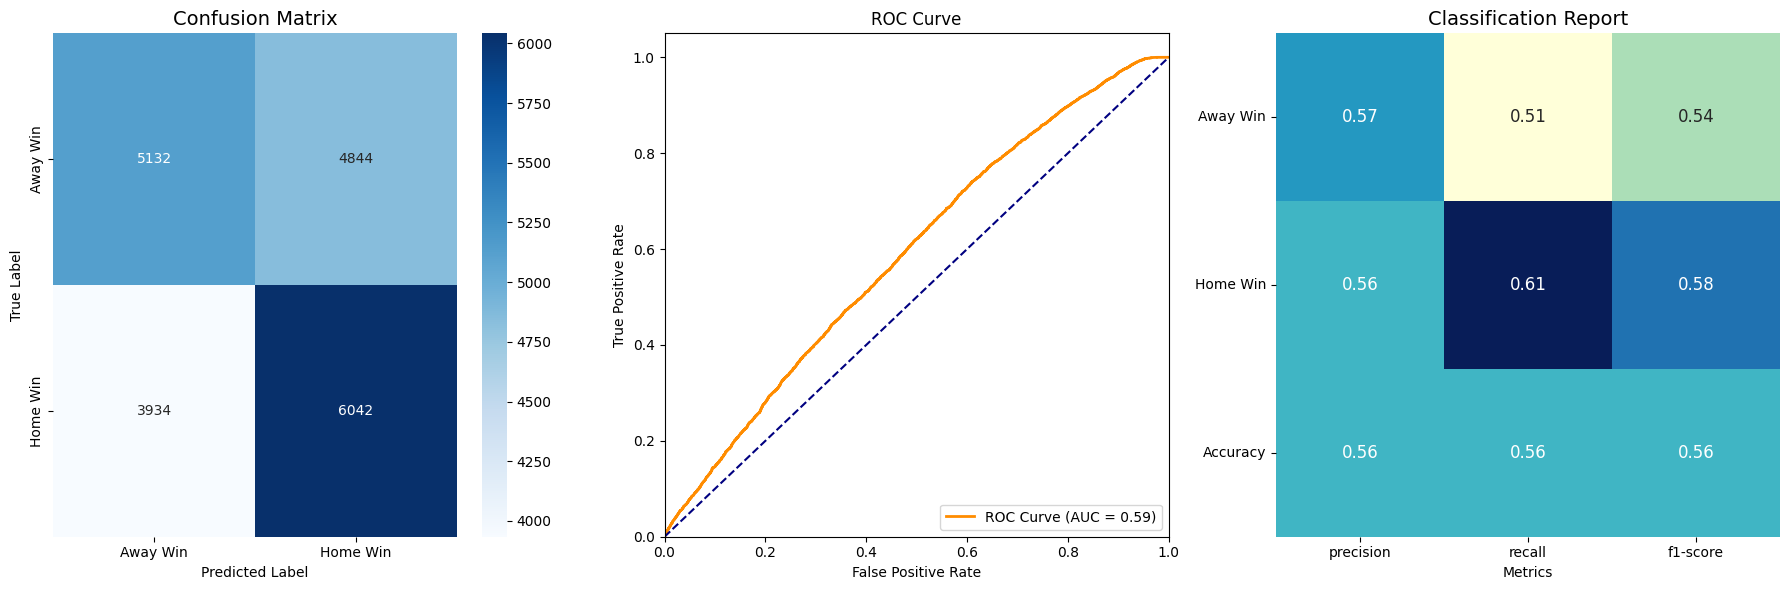

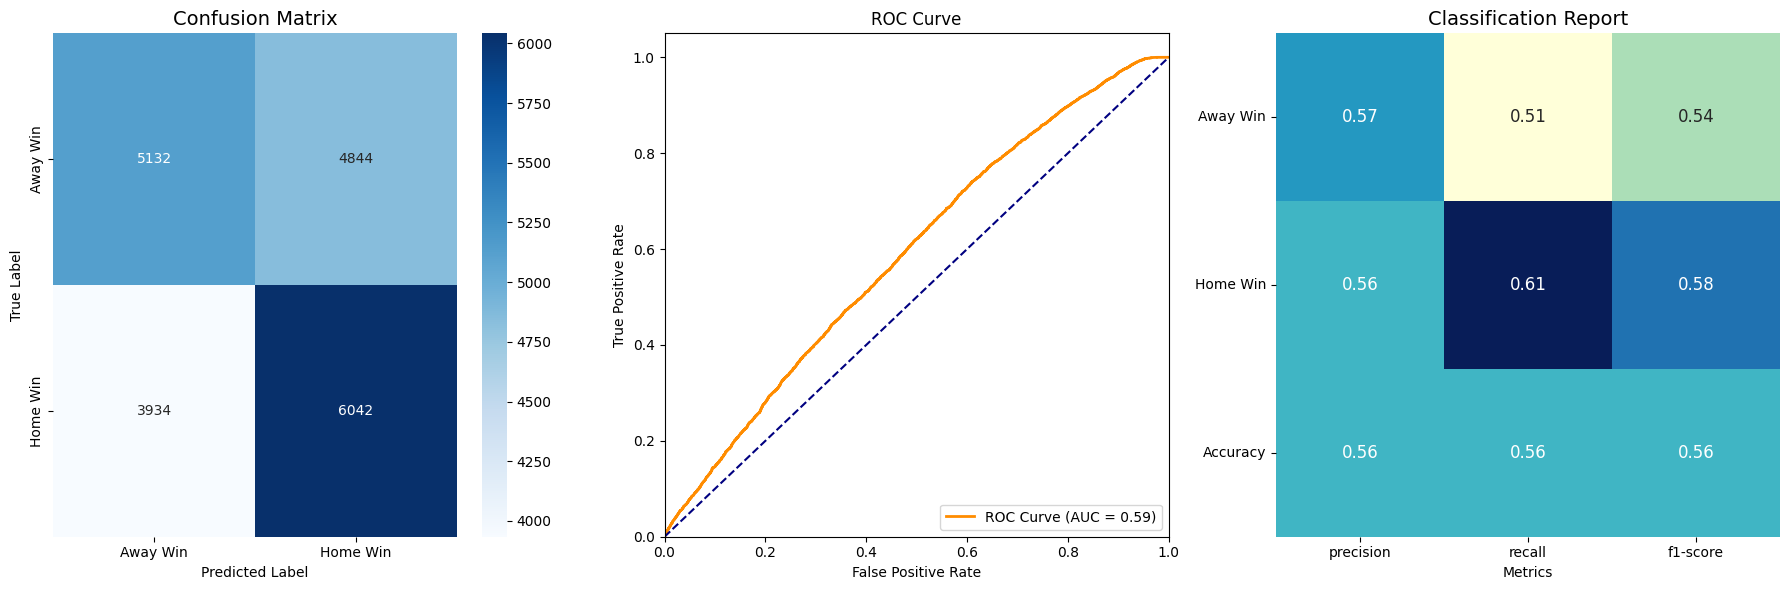

In [35]:
# Support Vector Machine
X_train_svm_2015, X_test_svm_2015, y_train_svm_2015, y_test_svm_2015 = split_svm_train_test_data(X_2015, y_2015)
svm_model_2015 = train_support_vector_machines(X_train_svm_2015, y_train_svm_2015)
y_pred_svm_2015 = predict_svm(svm_model_2015, X_test_svm_2015)
view_svm_results(svm_model_2015, y_test_svm_2015, y_pred_svm_2015)
plot_svm_diagnostics(svm_model_2015, X_test_svm_2015, y_test_svm_2015)


Epoch 1/100


C:\Users\sahil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1243/1247 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5241 - loss: 0.7889
Epoch 1: val_accuracy improved from -inf to 0.56100, saving model to best_model.keras
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5241 - loss: 0.7887 - val_accuracy: 0.5610 - val_loss: 0.6714 - learning_rate: 5.0000e-04
Epoch 2/100
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5558 - loss: 0.6808
Epoch 2: val_accuracy improved from 0.56100 to 0.56636, saving model to best_model.keras
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5558 - loss: 0.6808 - val_accuracy: 0.5664 - val_loss: 0.6679 - learning_rate: 5.0000e-04
Epoch 3/100
1244/1247 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5716 - loss: 0.6691
Epoch 3: val_accuracy improved from 0.56636 to 0.57548, saving model to best_model.keras
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5716 - loss: 0.6691 - val_accuracy: 0.5755 - val_loss: 0.6652 - learning_rate: 5.0000e-04
Epoch 4/100
1243/1247 ━━━━━━━━━━━━━━━

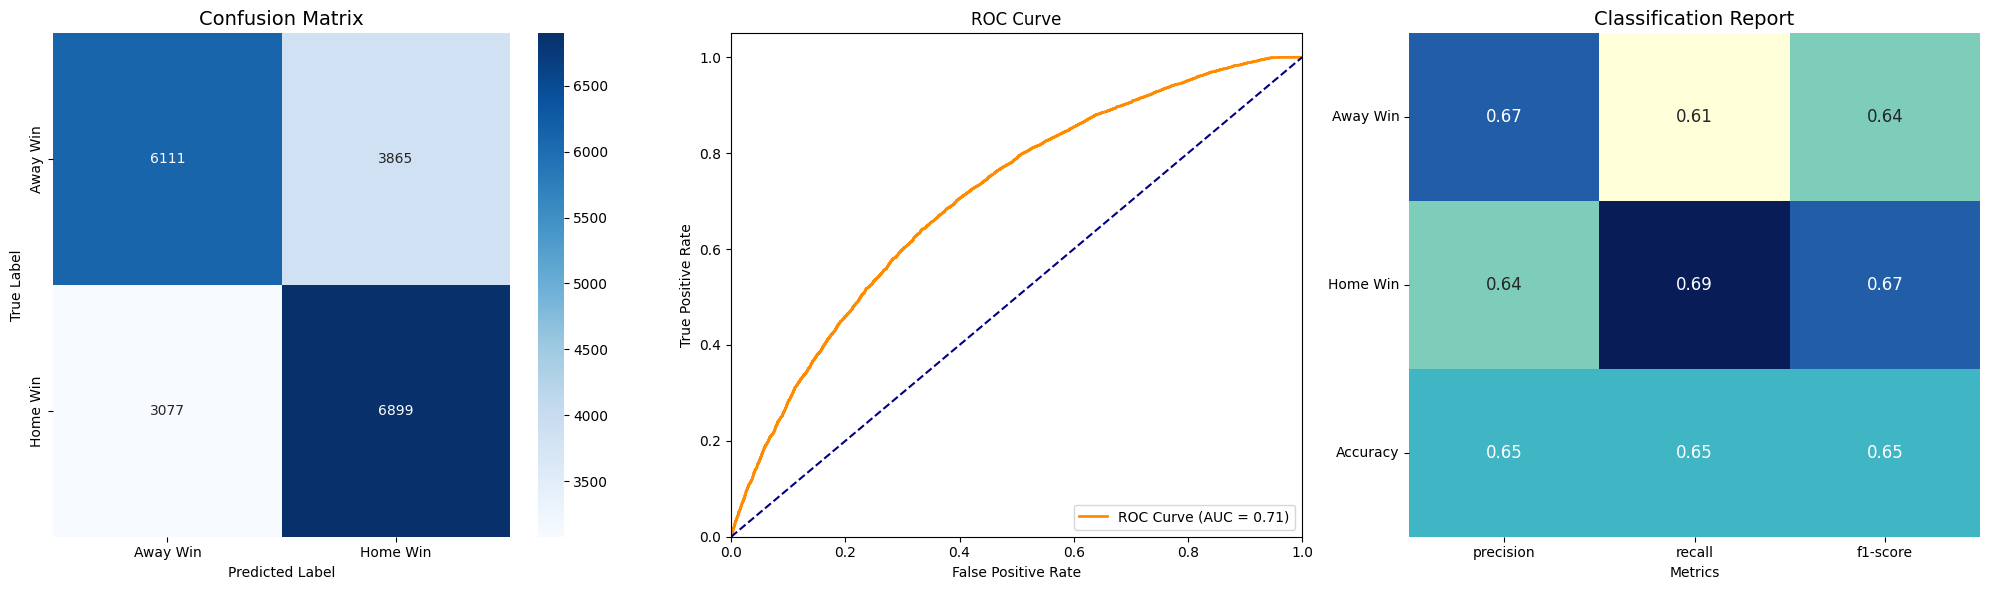

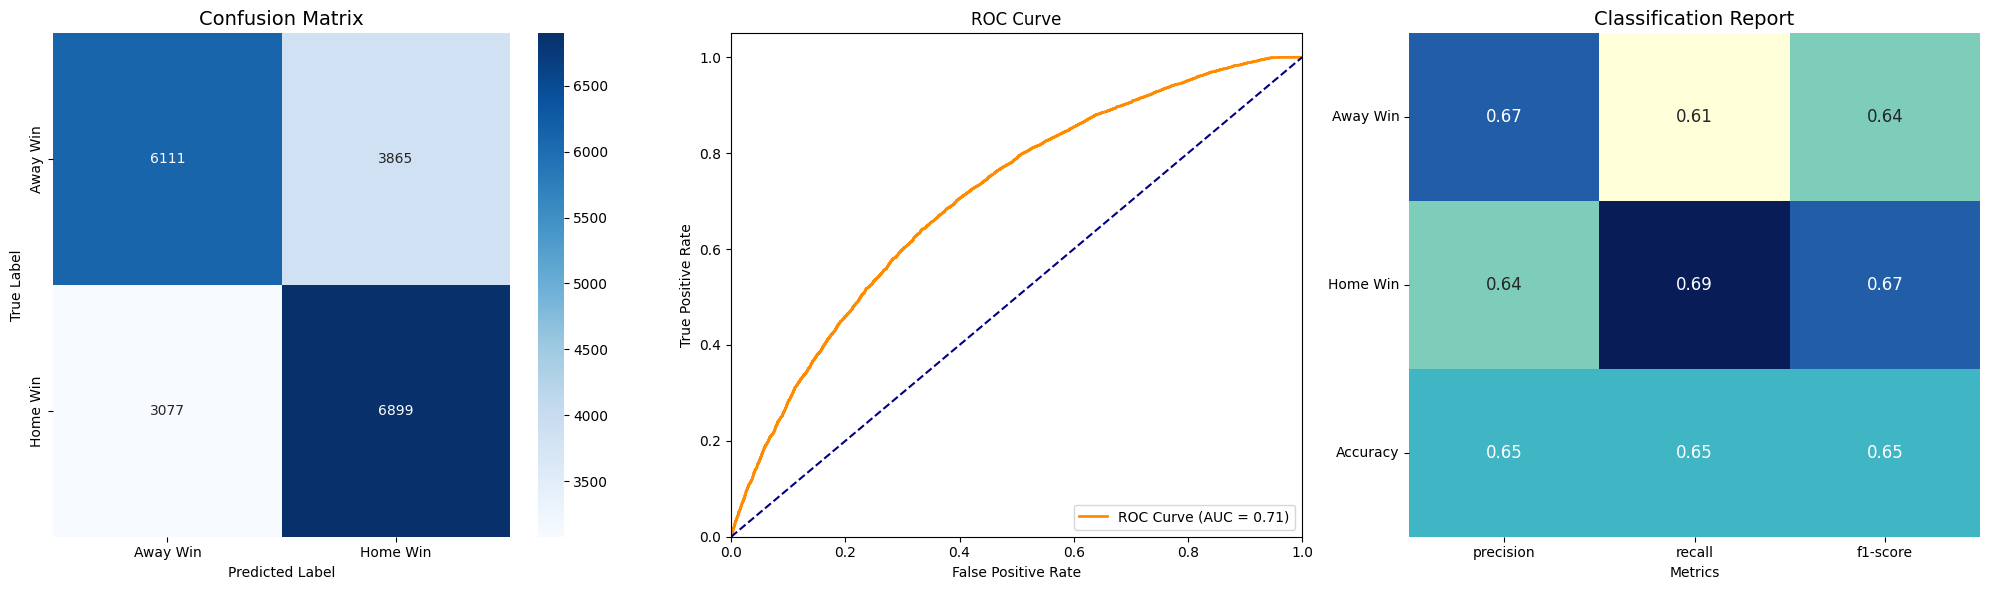

In [36]:
# Neural Networks
X_train_nn_2015, X_test_nn_2015, y_train_nn_2015, y_test_nn_2015 = split_nn_train_test_data(X_2015, y_2015)
nn_model_2015 = train_neural_network_model(X_train_nn_2015, X_test_nn_2015, y_train_nn_2015, y_test_nn_2015)
y_pred_nn_2015, y_pred_classes_nn_2015 = predict_neural_network_model(nn_model_2015, X_test_nn_2015)
evaluate_nn_metrics(y_test_nn_2015, y_pred_nn_2015, y_pred_classes_nn_2015)
plot_nn_diagnostics(nn_model_2015, X_test_nn_2015, y_test_nn_2015)


Applying PCA...
Reduced dimensions from 320 to 231 features
Accuracy: 0.7420809943865276

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73      9976
         1.0       0.72      0.79      0.75      9976

    accuracy                           0.74     19952
   macro avg       0.74      0.74      0.74     19952
weighted avg       0.74      0.74      0.74     19952


Top 5 most important features:
Feature 0: 0.0412
Feature 3: 0.0076
Feature 1: 0.0070
Feature 2: 0.0069
Feature 10: 0.0066
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73      9976
         1.0       0.72      0.79      0.75      9976

    accuracy                           0.74     19952
   macro avg       0.74      0.74      0.74     19952
weighted avg       0.74      0.74      0.74     19952



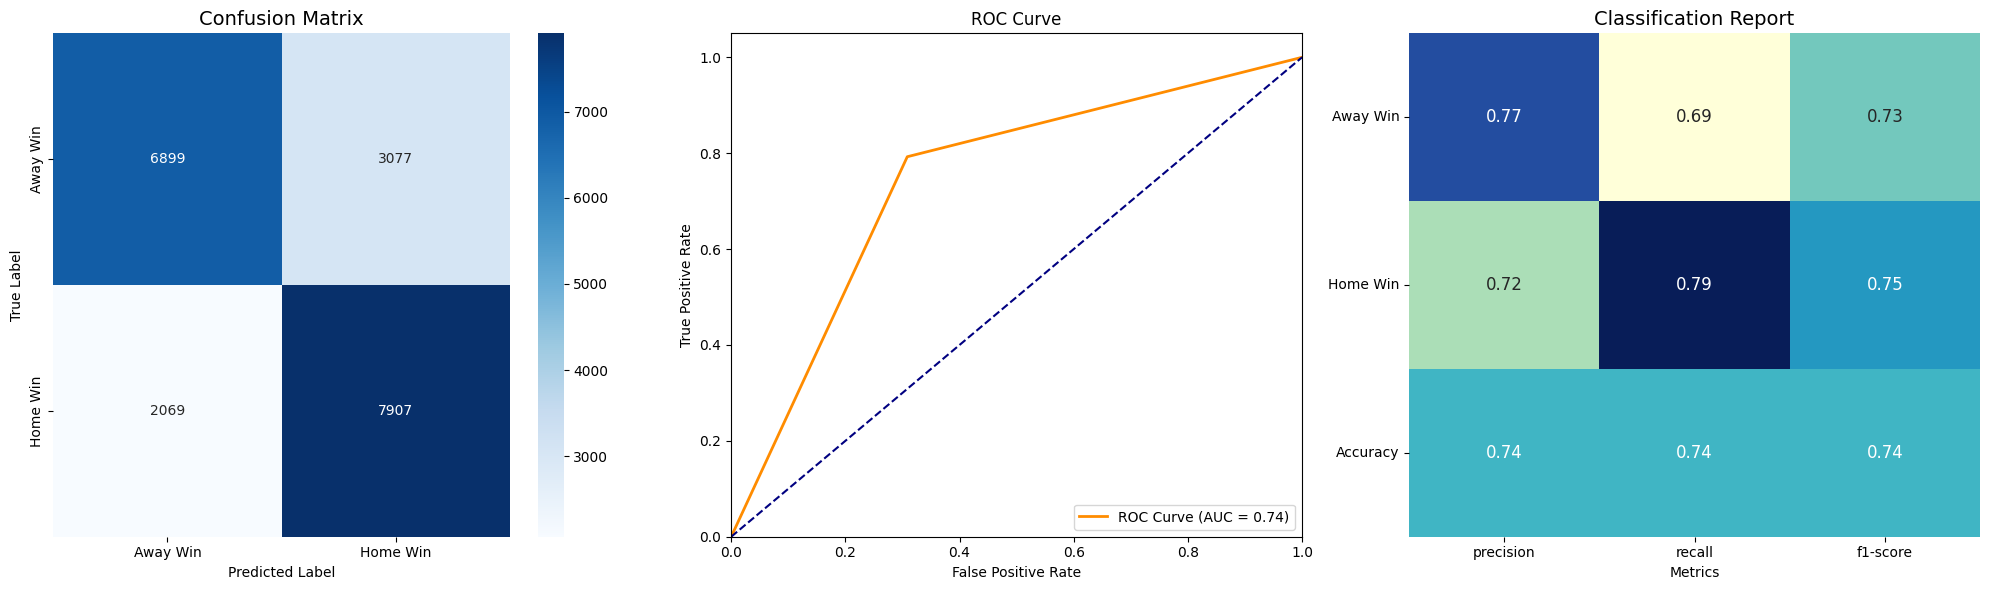

In [41]:
# Random Forests
X_train_rf_2015, X_test_rf_2015, y_train_rf_2015, y_test_rf_2015, rf_scaler_2015, rf_pca_2015 = split_random_forest_train_test_data(X_2015, y_2015)
rf_model_2015 = train_random_forest_model(X_train_rf_2015, y_train_rf_2015)
y_pred_rf_2015 = predict_random_forest_model(rf_model_2015, X_test_rf_2015)
evaluate_random_forest_model(rf_model_2015, y_test_rf_2015, y_pred_rf_2015)
plot_rf_diagnostics(rf_model_2015, X_test_rf_2015, y_test_rf_2015)


Scaling features...
Applying PCA...
Reduced dimensions from 320 to 231 features

Performing cross-validation...
Cross-validation scores: [0.65359747 0.64862223 0.65354686]
Mean CV accuracy: 0.652 (+/- 0.005)

Training final model...

Model Evaluation:
Accuracy: 0.6950180433039295

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65      9976
         1.0       0.66      0.82      0.73      9976

    accuracy                           0.70     19952
   macro avg       0.71      0.70      0.69     19952
weighted avg       0.71      0.70      0.69     19952


Prediction Confidence Analysis:
Mean confidence: 0.845
Min confidence: 0.500
Max confidence: 1.000


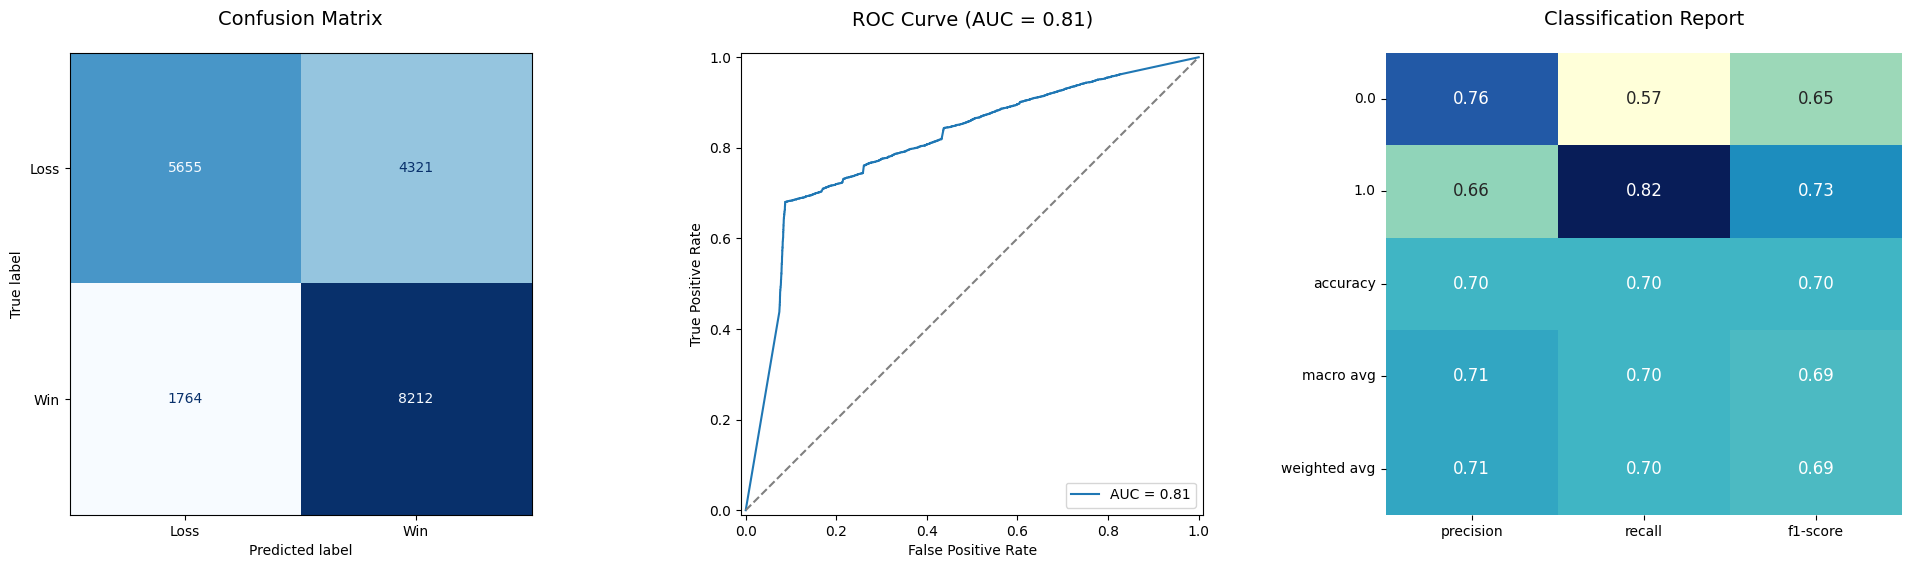

In [42]:
# K Nearest Neighbor
X_train_knn_2015, X_test_knn_2015, y_train_knn_2015, y_test_knn_2015, knn_scaler_2015, knn_pca_2015 = split_knn_train_test_data(X_2015, y_2015)
knn_model_2015 = train_knn_model(X_train_knn_2015, y_train_knn_2015)
y_pred_knn_2015, y_proba_knn_2015 = predict_knn_model(knn_model_2015, X_test_knn_2015)
evaluate_knn_model(knn_model_2015, y_test_knn_2015, y_pred_knn_2015, y_proba_knn_2015)
plot_knn_diagnostics(knn_model_2015, X_test_knn_2015, y_test_knn_2015)


In [ ]:
# Load dataset chunks year by year
# each dataset will be  loaded with current year + 2 preceding years
def generate_datasets(start_year, end_year):
    datasets = {}
    for year in range(start_year, end_year):
        print("Dataset Year: ", year)
        raw_dataset = preprocess_dataset_by_year(year)
        raw_dataset = handle_class_imbalance(raw_dataset)
        players_list_by_season_and_team = get_players_list_by_season_and_team(raw_dataset)
        raw_dataset, player_name_mapping = player_name_encoding(raw_dataset)
        raw_dataset = feature_engineering(raw_dataset)
        datasets[year] = {'dataset': raw_dataset, 'players_mappings': player_name_mapping, 'players_list_by_season': players_list_by_season_and_team}
    return datasets

In [51]:
# Generate models for Random Forests using year-on-year datasets
def generate_random_forest_model(X, y):
    # Random Forests
    X_train_rf, X_test_rf, y_train_rf, y_test_rf, scaler, pca = split_random_forest_train_test_data(X, y)
    rf_model = train_random_forest_model(X_train_rf, y_train_rf)
    y_pred_rf = predict_random_forest_model(rf_model, X_test_rf)
    evaluate_random_forest_model(rf_model, y_test_rf, y_pred_rf)
    plot_rf_diagnostics(rf_model, X_test_rf, y_test_rf)
    return rf_model, scaler, pca

In [52]:
# Generate models for KNN using year-on-year datasets
def generate_knn_model(X, y):
    X_train_knn, X_test_knn, y_train_knn, y_test_knn, scalar, pca = split_knn_train_test_data(X, y)
    knn_model = train_knn_model(X_train_knn, y_train_knn)
    y_pred_knn, y_proba_knn = predict_knn_model(knn_model, X_test_knn)
    evaluate_knn_model(knn_model, y_test_knn, y_pred_knn, y_proba_knn)
    plot_knn_diagnostics(knn_model, X_test_knn, y_test_knn)
    return knn_model, scalar, pca

In [53]:
# Generate a dictionary of models for both Random forests and knn
def generate_models(datasets):
    models = {}
    for year in datasets:
        X_home, X_away, X_stats, y = data_transformation(datasets[year]['dataset'])
        embedding_model = generate_player_embedding(X_home, X_away, X_stats, y, datasets[year]['players_mappings'])
        X, y = map_player_embedding(datasets[year]['dataset'], embedding_model)
        rf_model, rf_scaler, rf_pca = generate_random_forest_model(X, y)
        knn_model, knn_scalar, knn_pca = generate_knn_model(X, y)
        models[year] = {'embedding_model': embedding_model, 'random_forest': [rf_model, rf_scaler, knn_pca], 'knn': [knn_model, knn_scalar, knn_pca]}
    return models

In [ ]:
# Code to save the generated models
def save_generated_models(models, datasets):
    for year in models:
        joblib.dump(models[year]['embedding_model'], 'models/player_embeddings/player_embeddings_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][0], 'models/random_forest/rf_model_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][1], 'models/random_forest/rf_scalar_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][2], 'models/random_forest/rf_pca_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][0], 'models/knn/knn_model_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][1], 'models/knn/knn_scalar_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][2], 'models/knn/knn_pca_' + str(year) + '.pkl')
        player_list = json.dumps(datasets[year]['players_list_by_season'], indent = 4)
        with open('models/players_list_by_model/player_list_' + str(year) + '.json', 'w') as outfile:
            outfile.write(player_list)
        player_mapping = json.dumps(datasets[year]['players_mappings'], indent = 4)
        with open('models/player_mappings/player_mapping_' + str(year) + '.json', 'w') as outfile:
            outfile.write(player_mapping)


In [149]:
# Code to Load the saved models
def load_generated_models():
    start_year = 2007
    end_year = 2016
    models = {}
    for year in range(start_year, end_year):
        models[year] = {'random_forest': joblib.load('models/random_forest/rf_model_' + str(year) + '.pkl'), 'knn': 'models/knn/knn_model_' + str(year) + '.pkl'}
    return models


Dataset Year:  2007


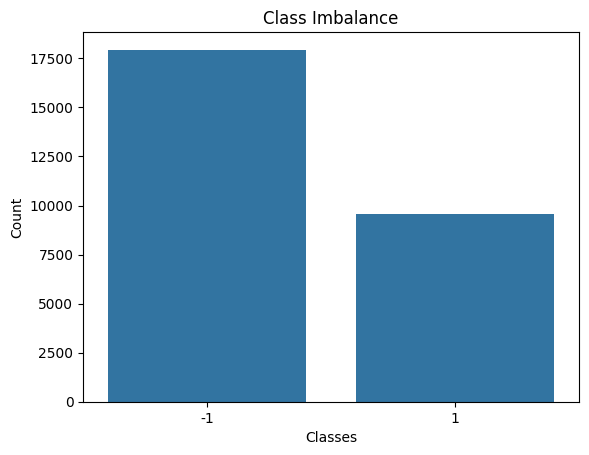

17942   9558
outcome
-1    17942
 1    17942
Name: count, dtype: int64


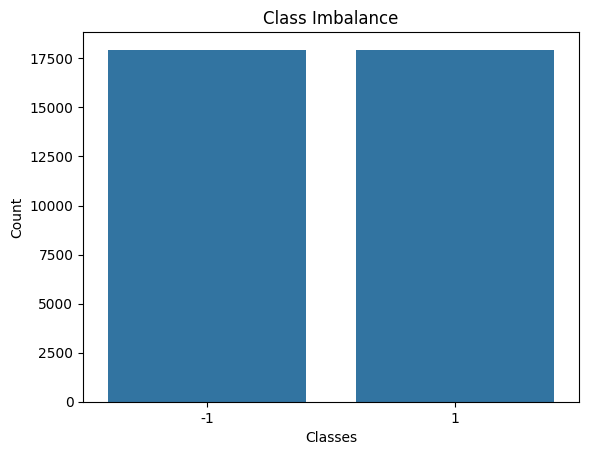

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             13.579868
3p_pct_home             54.570282
ftm_home                 0.000000
ft_pct_home             59.341211
ts_pct_home             11.573403
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

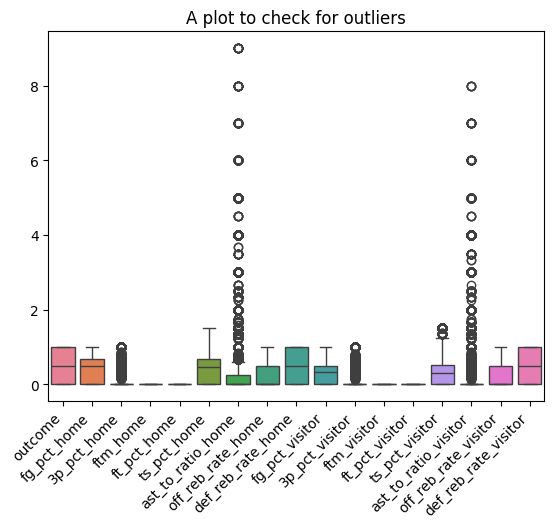

Dataset Year:  2008


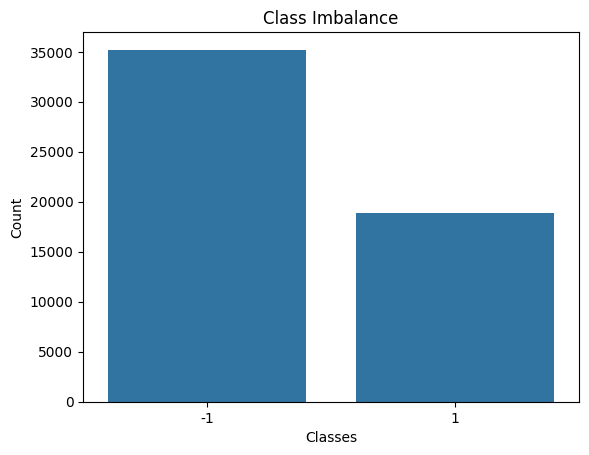

35207   18886
outcome
-1    35207
 1    35207
Name: count, dtype: int64


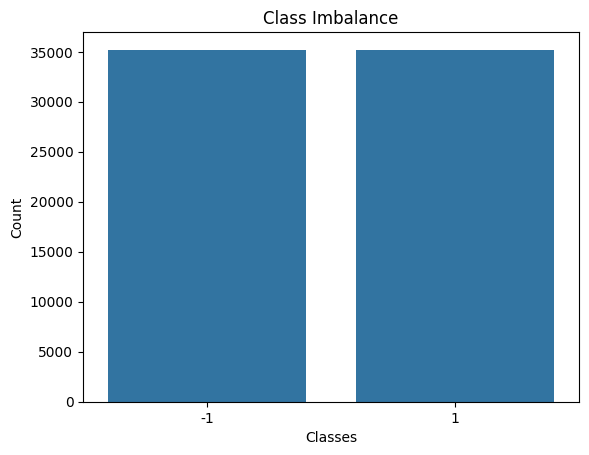

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             13.295651
3p_pct_home             52.925555
ftm_home                 0.000000
ft_pct_home             59.429943
ts_pct_home             11.470730
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

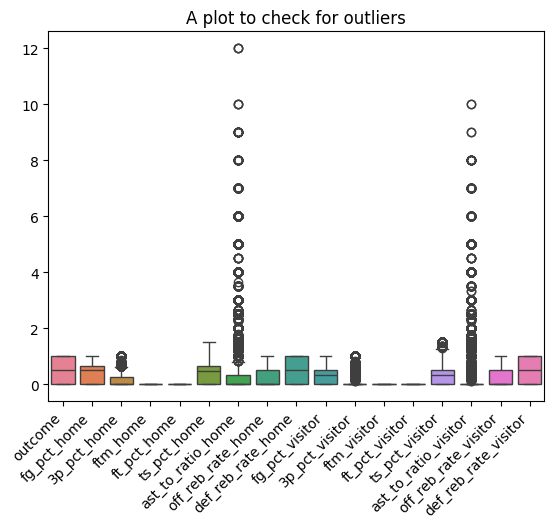

Dataset Year:  2009


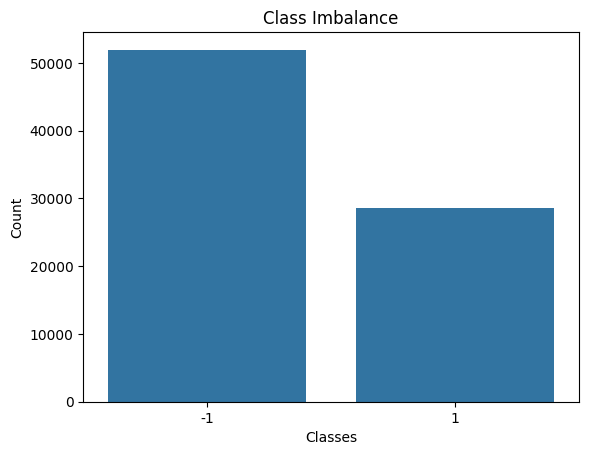

51958   28542
outcome
-1    51958
 1    51958
Name: count, dtype: int64


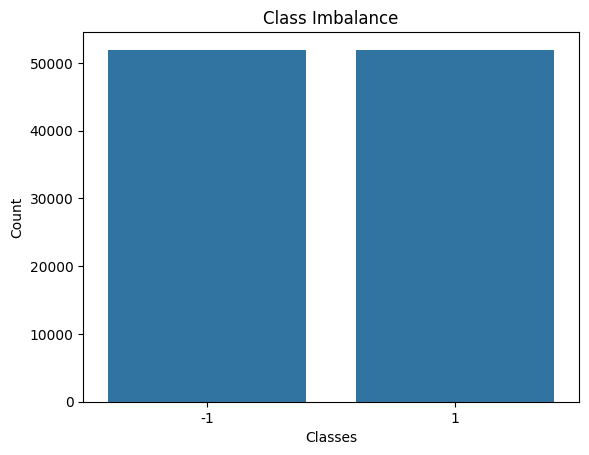

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             12.511067
3p_pct_home             52.121906
ftm_home                 0.000000
ft_pct_home             58.995727
ts_pct_home             10.738481
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

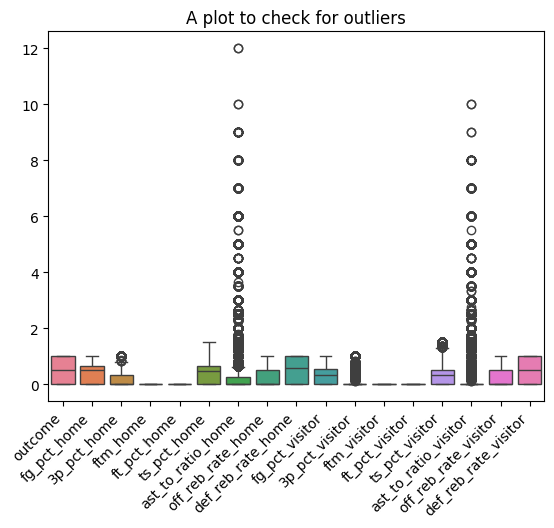

Dataset Year:  2010


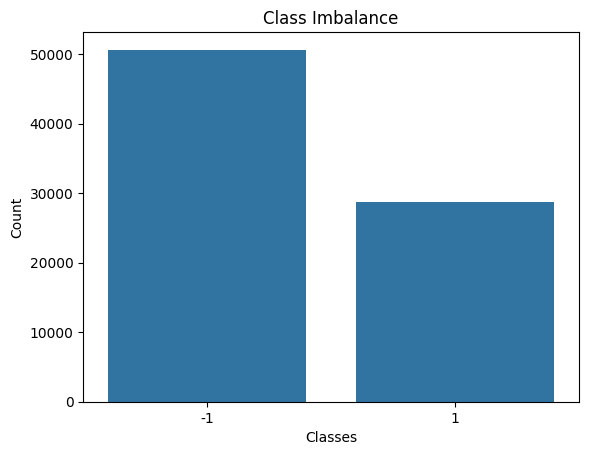

50639   28705
outcome
-1    50639
 1    50639
Name: count, dtype: int64


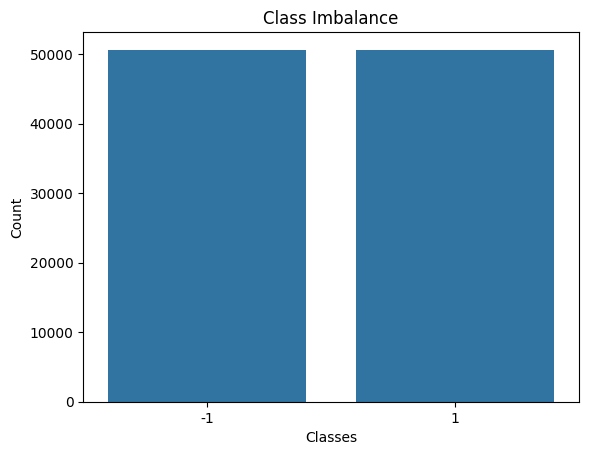

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             11.539525
3p_pct_home             50.675369
ftm_home                 0.000000
ft_pct_home             58.618851
ts_pct_home              9.866901
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

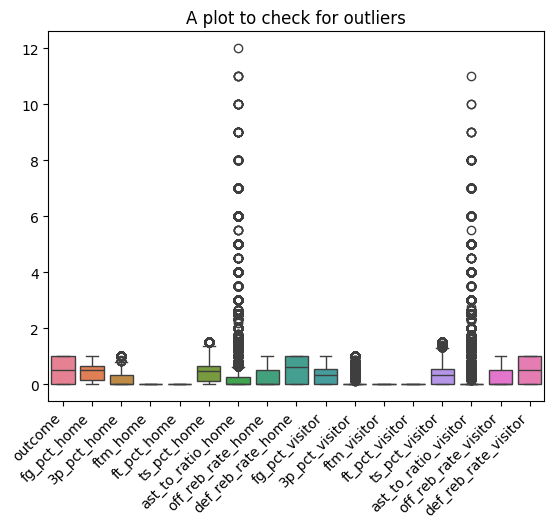

Dataset Year:  2011


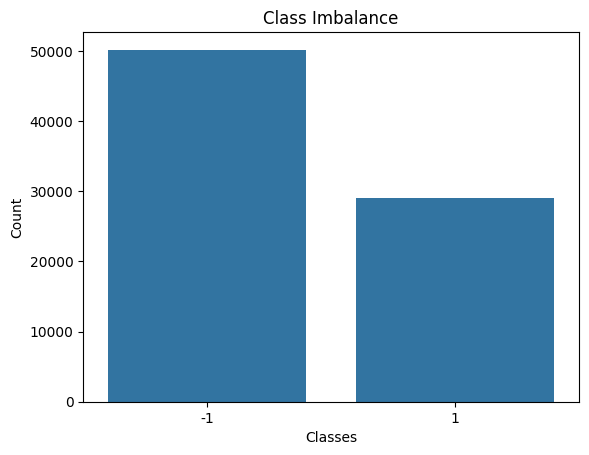

50198   29000
outcome
-1    50198
 1    50198
Name: count, dtype: int64


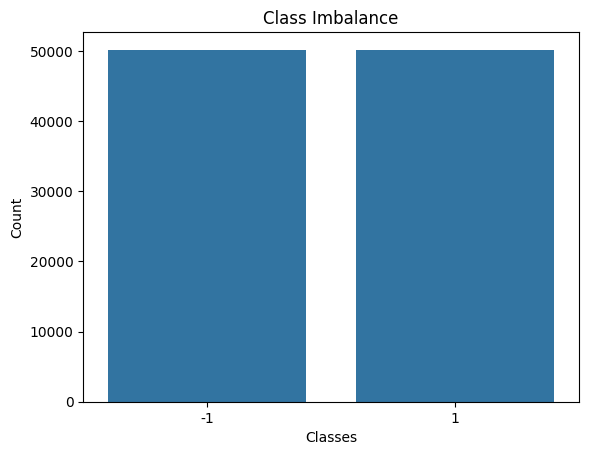

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.792263
3p_pct_home             50.043826
ftm_home                 0.000000
ft_pct_home             58.548149
ts_pct_home              9.128850
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

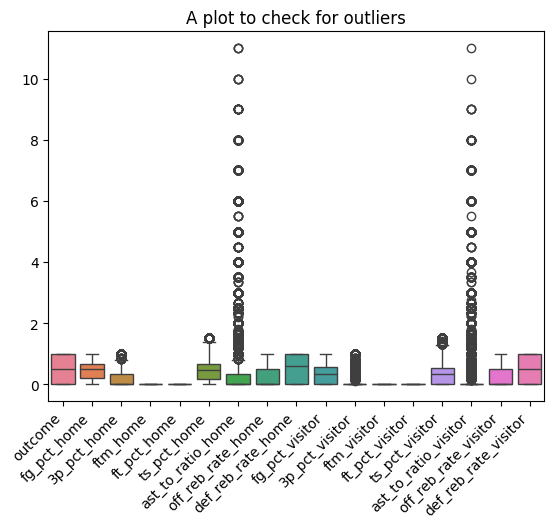

Dataset Year:  2012


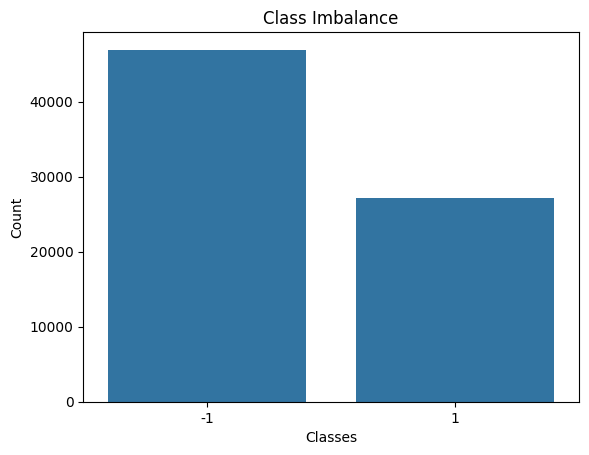

46901   27131
outcome
-1    46901
 1    46901
Name: count, dtype: int64


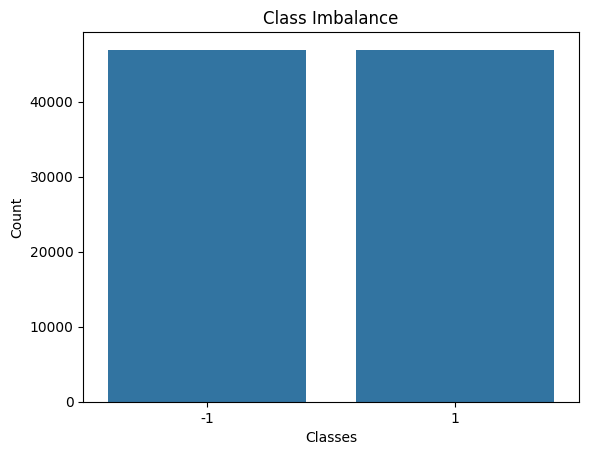

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.808938
3p_pct_home             49.939234
ftm_home                 0.000000
ft_pct_home             59.556299
ts_pct_home              9.179975
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

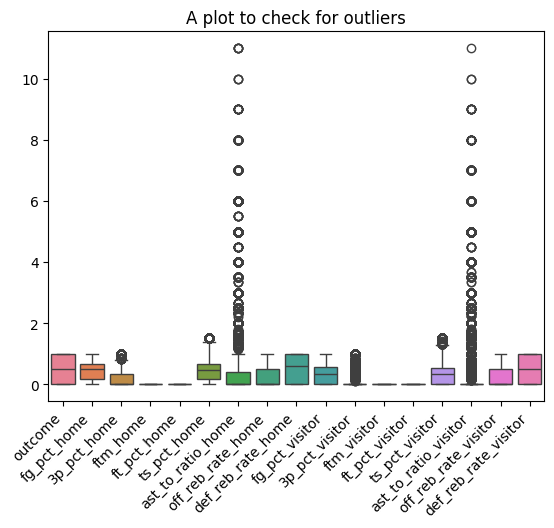

Dataset Year:  2013


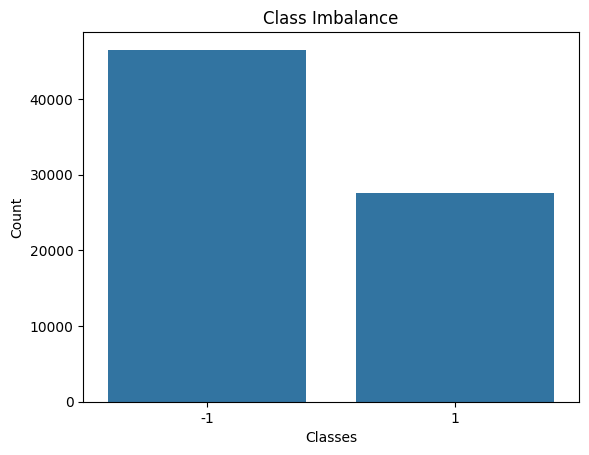

46499   27540
outcome
-1    46499
 1    46499
Name: count, dtype: int64


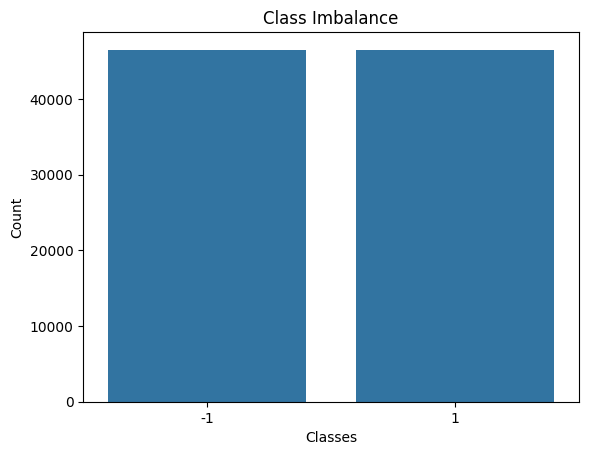

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.051829
3p_pct_home             48.623626
ftm_home                 0.000000
ft_pct_home             60.587324
ts_pct_home              8.471150
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

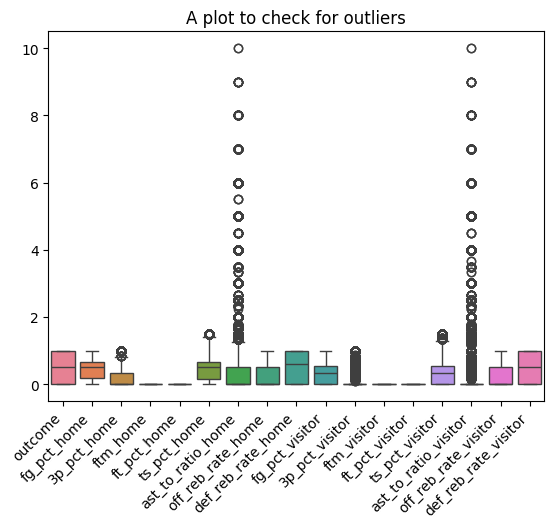

Dataset Year:  2014


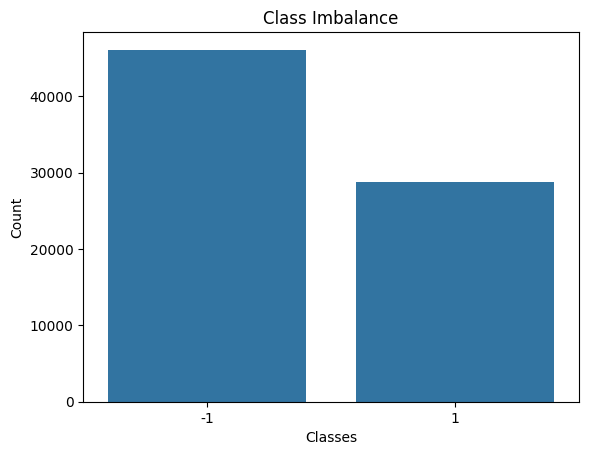

46112   28741
outcome
-1    46112
 1    46112
Name: count, dtype: int64


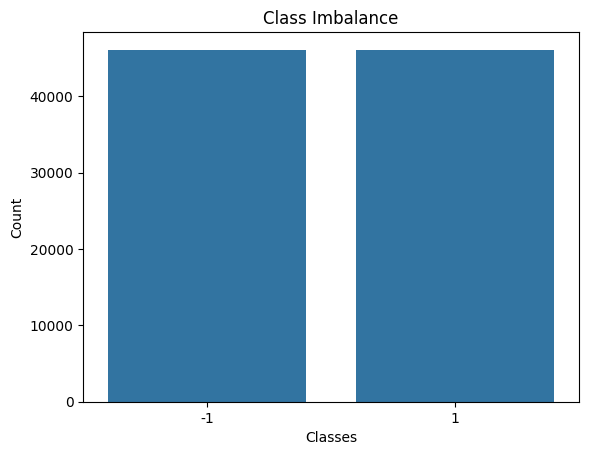

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              8.265744
3p_pct_home             46.415250
ftm_home                 0.000000
ft_pct_home             60.389920
ts_pct_home              6.629511
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

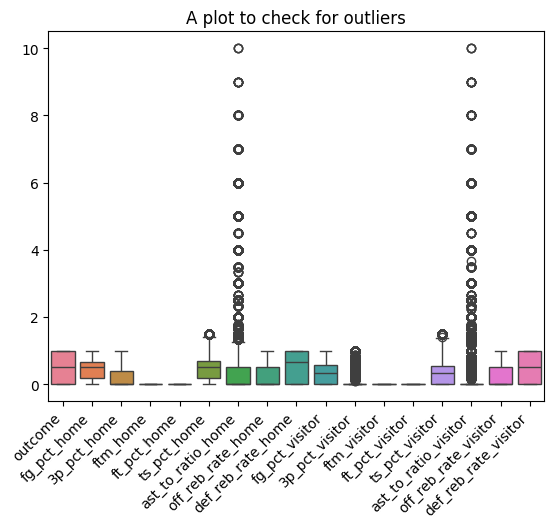

Dataset Year:  2015


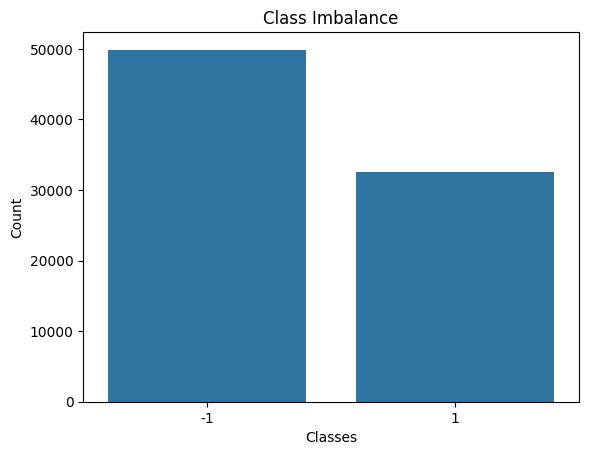

49878   32502
outcome
-1    49878
 1    49878
Name: count, dtype: int64


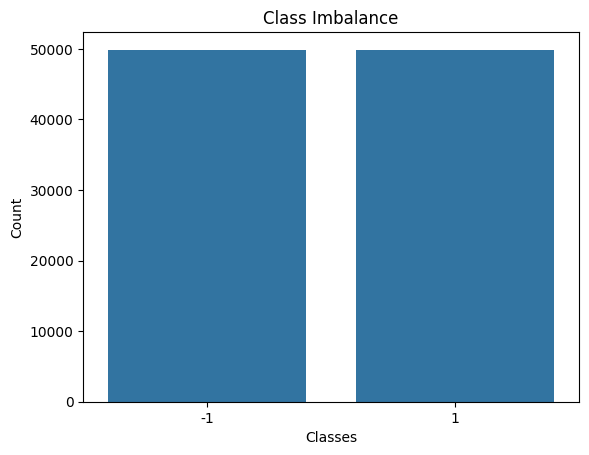

<class 'dict'>
Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              5.956534
3p_pct_home             44.215887
ftm_home                 0.000000
ft_pct_home             60.499619
ts_pct_home              4.177192
ast_to_ratio_home       

C:\Users\sahil\AppData\Local\Temp\ipykernel_14212\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


Percentage of null values for each column:
season                  0.0
home_team               0.0
away_team               0.0
home_0                  0.0
home_1                  0.0
home_2                  0.0
home_3                  0.0
home_4                  0.0
away_0                  0.0
away_1                  0.0
away_2                  0.0
away_3                  0.0
away_4                  0.0
pts_home                0.0
pct_home                0.0
pct_2_home              0.0
pct_3_home              0.0
pts_visitor             0.0
pct_visitor             0.0
pct_2_visitor           0.0
pct_3_visitor           0.0
outcome                 0.0
fg_pct_home             0.0
3p_pct_home             0.0
ftm_home                0.0
ft_pct_home             0.0
ts_pct_home             0.0
ast_to_ratio_home       0.0
off_reb_rate_home       0.0
def_reb_rate_home       0.0
fg_pct_visitor          0.0
3p_pct_visitor          0.0
ftm_visitor             0.0
ft_pct_visitor          0.0
ts_pc

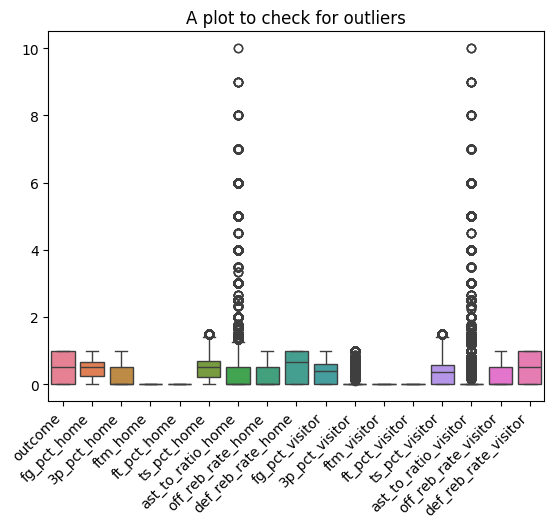

In [56]:
year_on_year_datasets = generate_datasets(2007, 2016)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     14,624 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     14,624 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 336)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │     10,784 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,065 (156.50 KB)

 Trainable params: 40,065 (156.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8022 - loss: 0.4448 - val_accuracy: 0.8469 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.2332 - val_accuracy: 0.8720 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9175 - loss: 0.1955 - val_accuracy: 0.8694 - val_loss: 0.2731 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9319 - loss: 0.1636 - val_accuracy: 0.8969 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9442 - loss: 0.1417 - val_accuracy: 0.9238 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9560 - loss: 0.1146 - val_accuracy: 0.9209 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9660 - loss: 0.0948 - 

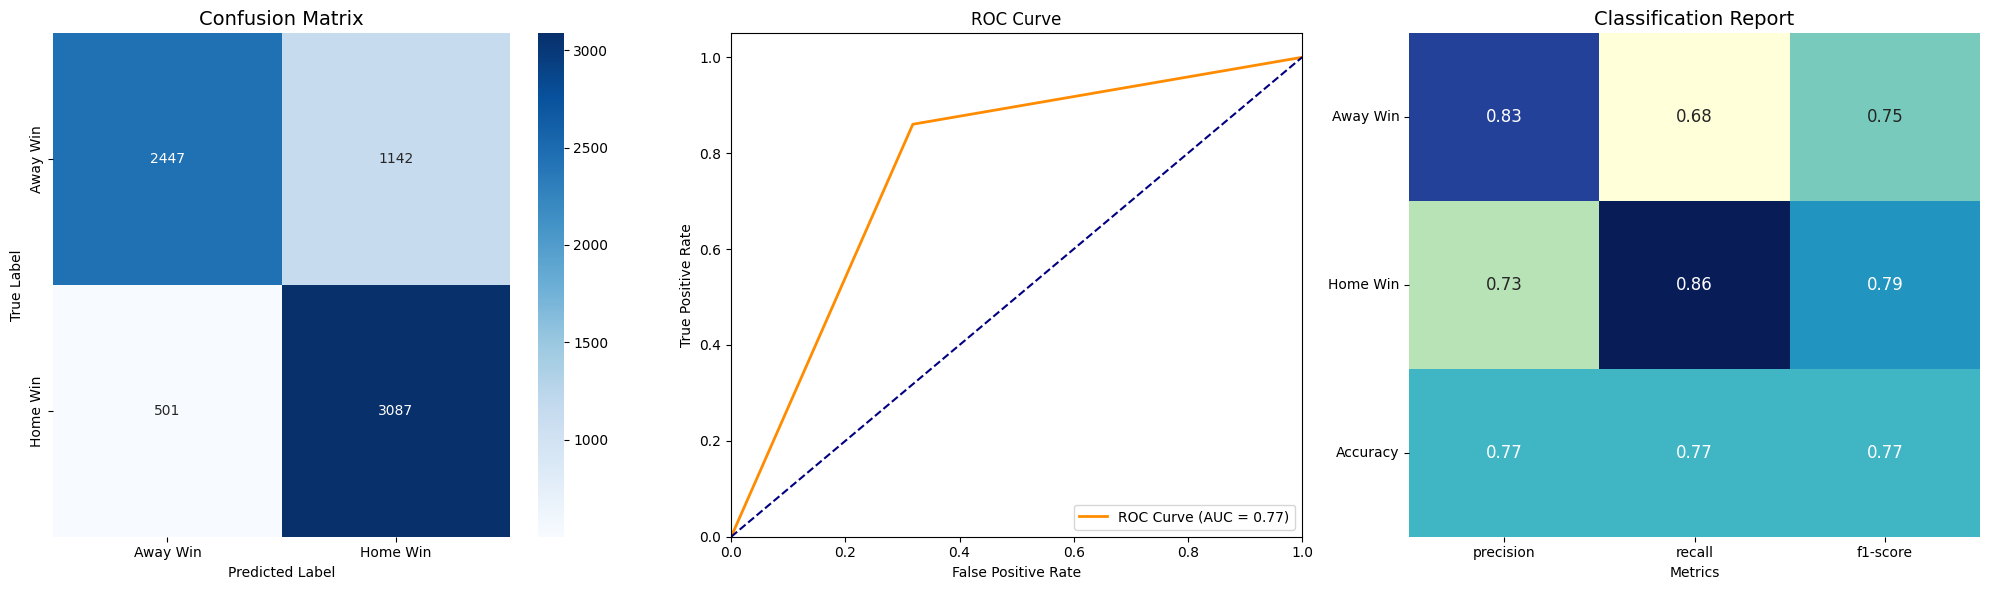

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 191 features

Performing cross-validation...
Cross-validation scores: [0.71115059 0.69275786 0.69840109]
Mean CV accuracy: 0.701 (+/- 0.015)

Training final model...

Model Evaluation:
Accuracy: 0.7393061167618782

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.60      0.70      3589
         1.0       0.69      0.88      0.77      3588

    accuracy                           0.74      7177
   macro avg       0.76      0.74      0.73      7177
weighted avg       0.76      0.74      0.73      7177


Prediction Confidence Analysis:
Mean confidence: 0.876
Min confidence: 0.500
Max confidence: 1.000


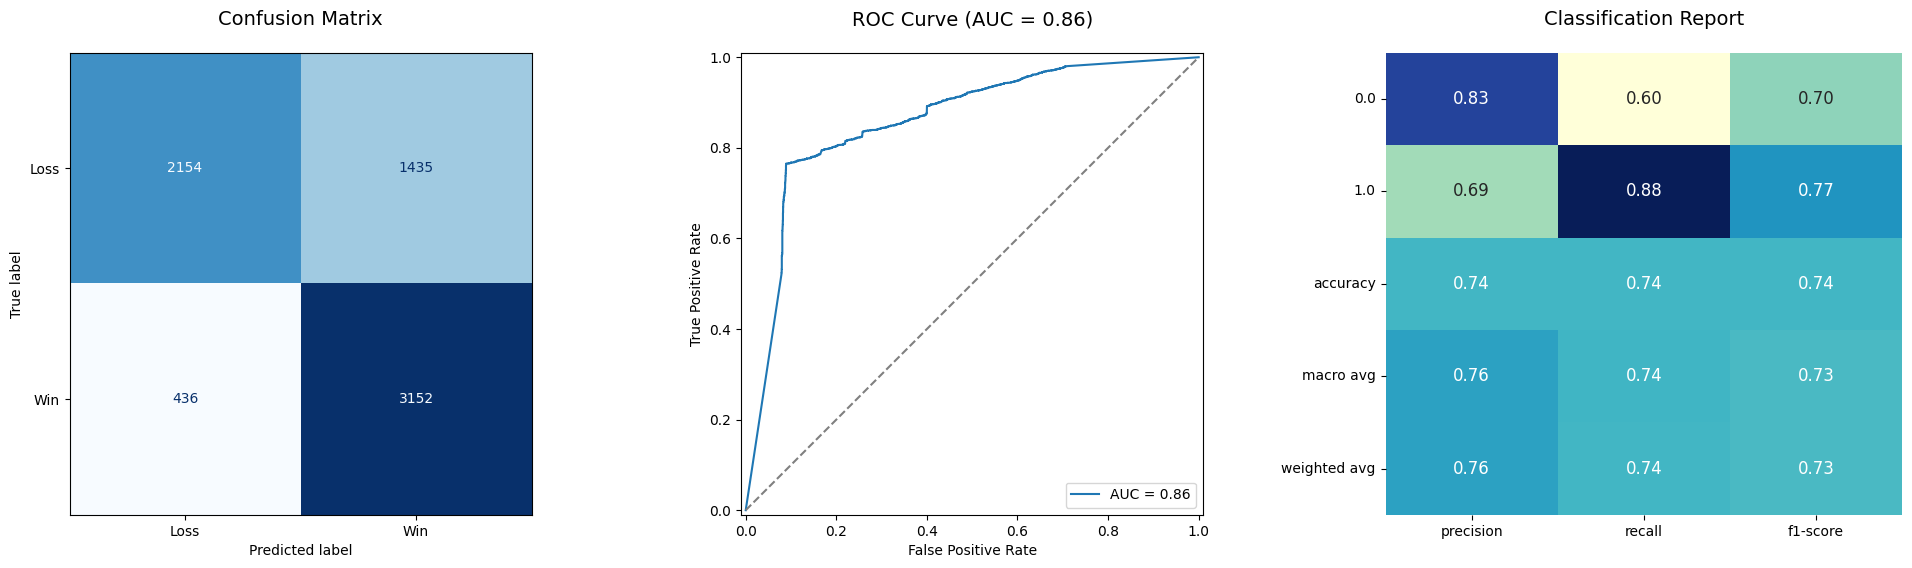

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     17,184 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     17,184 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 336)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │     10,784 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,185 (176.50 KB)

 Trainable params: 45,185 (176.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8526 - loss: 0.3643 - val_accuracy: 0.8419 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 2/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9148 - loss: 0.1987 - val_accuracy: 0.8878 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 3/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9339 - loss: 0.1588 - val_accuracy: 0.9117 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 4/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9463 - loss: 0.1349 - val_accuracy: 0.8875 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 5/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9560 - loss: 0.1144 - val_accuracy: 0.9260 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 6/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9650 - loss: 0.0948 - val_accuracy: 0.9161 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 7/50
1761/1761 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9712 - l

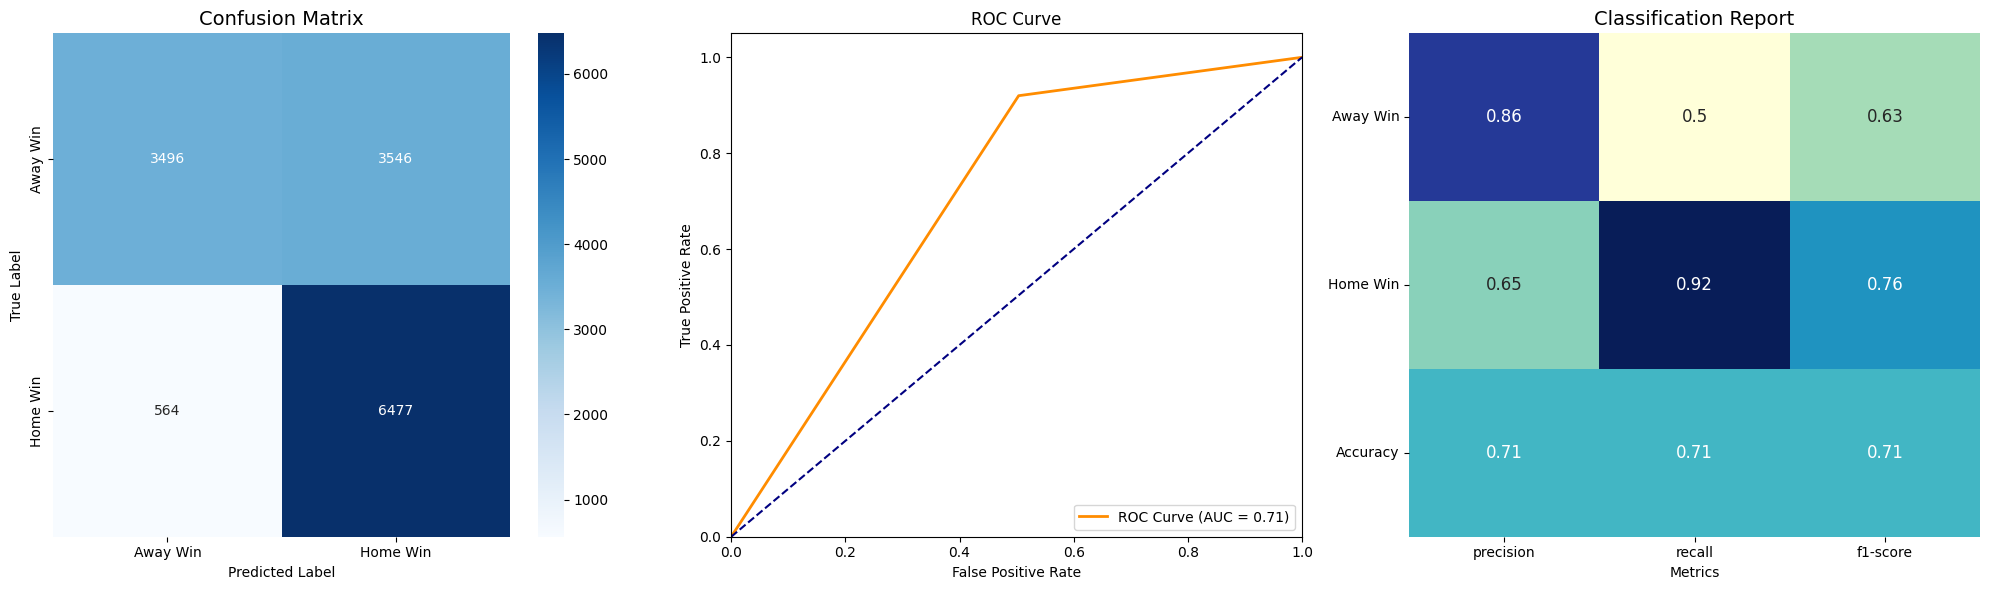

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 219 features

Performing cross-validation...
Cross-validation scores: [0.69894019 0.70186931 0.68972679]
Mean CV accuracy: 0.697 (+/- 0.010)

Training final model...

Model Evaluation:
Accuracy: 0.7394021160264148

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.60      0.70      7042
         1.0       0.69      0.88      0.77      7041

    accuracy                           0.74     14083
   macro avg       0.76      0.74      0.73     14083
weighted avg       0.76      0.74      0.73     14083


Prediction Confidence Analysis:
Mean confidence: 0.874
Min confidence: 0.500
Max confidence: 1.000


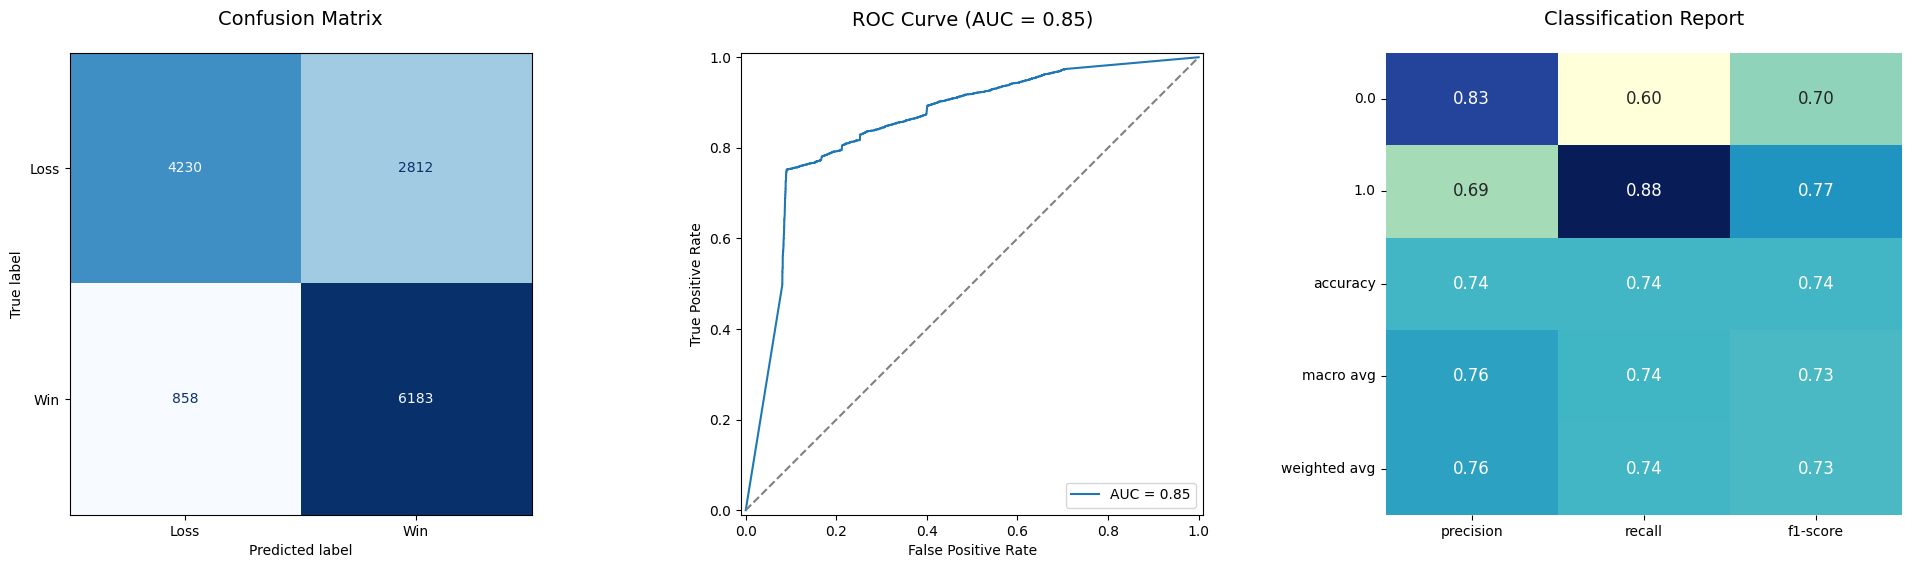

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,296 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,296 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 336)       │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │     10,784 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 49,409 (193.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8445 - loss: 0.3586 - val_accuracy: 0.8600 - val_loss: 0.3005 - learning_rate: 0.0010
Epoch 2/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9112 - loss: 0.2083 - val_accuracy: 0.8986 - val_loss: 0.2309 - learning_rate: 0.0010
Epoch 3/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9312 - loss: 0.1662 - val_accuracy: 0.9085 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 4/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9439 - loss: 0.1371 - val_accuracy: 0.8999 - val_loss: 0.2337 - learning_rate: 0.0010
Epoch 5/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9557 - loss: 0.1160 - val_accuracy: 0.9119 - val_loss: 0.2195 - learning_rate: 0.0010
Epoch 6/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9617 - loss: 0.1007 - val_accuracy: 0.9206 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 7/50
2598/2598 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9699 

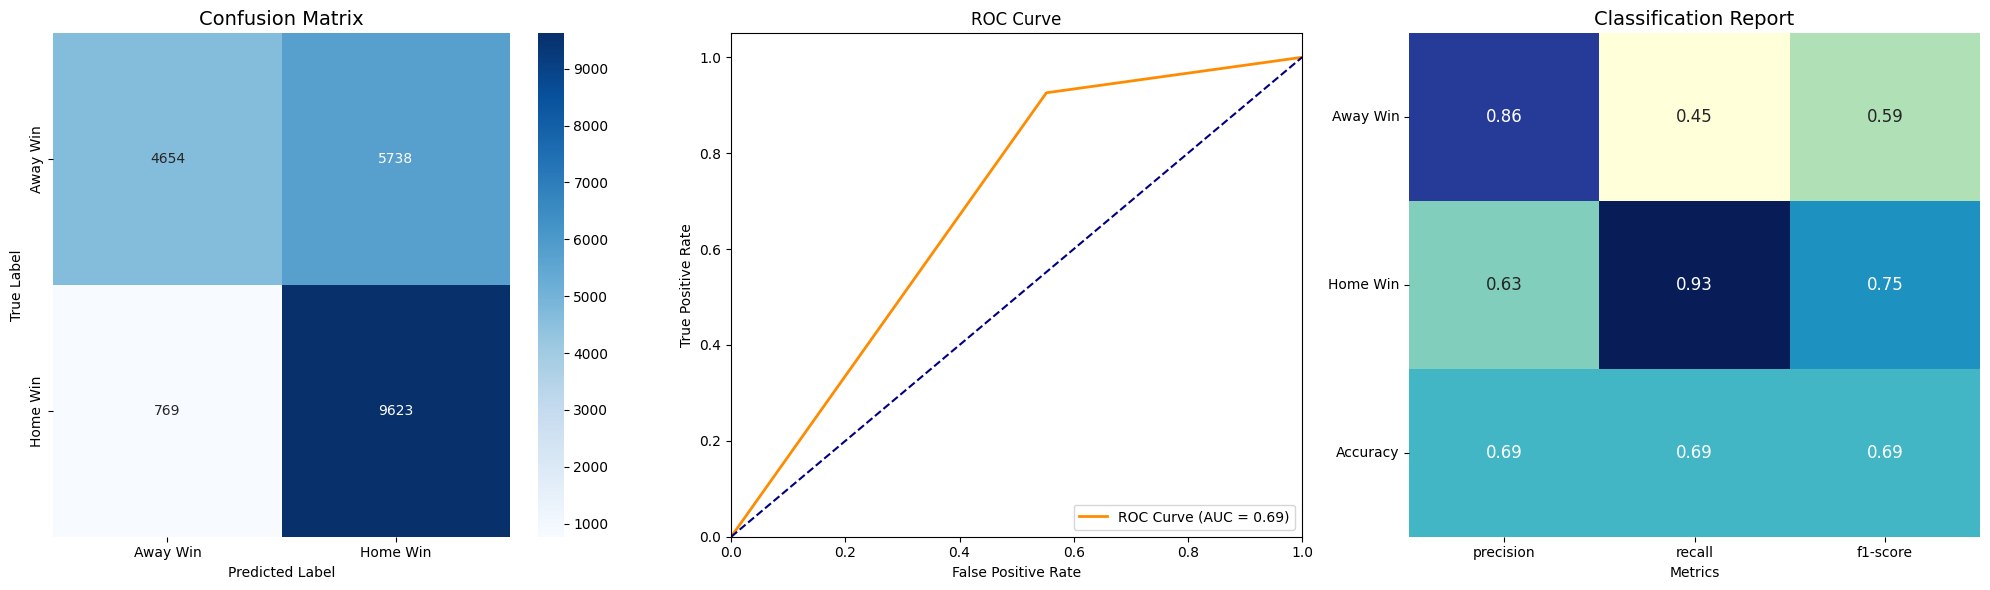

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 238 features

Performing cross-validation...
Cross-validation scores: [0.69149435 0.685107   0.6897149 ]
Mean CV accuracy: 0.689 (+/- 0.005)

Training final model...

Model Evaluation:
Accuracy: 0.7333525789068515

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69     10392
         1.0       0.69      0.86      0.76     10392

    accuracy                           0.73     20784
   macro avg       0.75      0.73      0.73     20784
weighted avg       0.75      0.73      0.73     20784


Prediction Confidence Analysis:
Mean confidence: 0.870
Min confidence: 0.500
Max confidence: 1.000


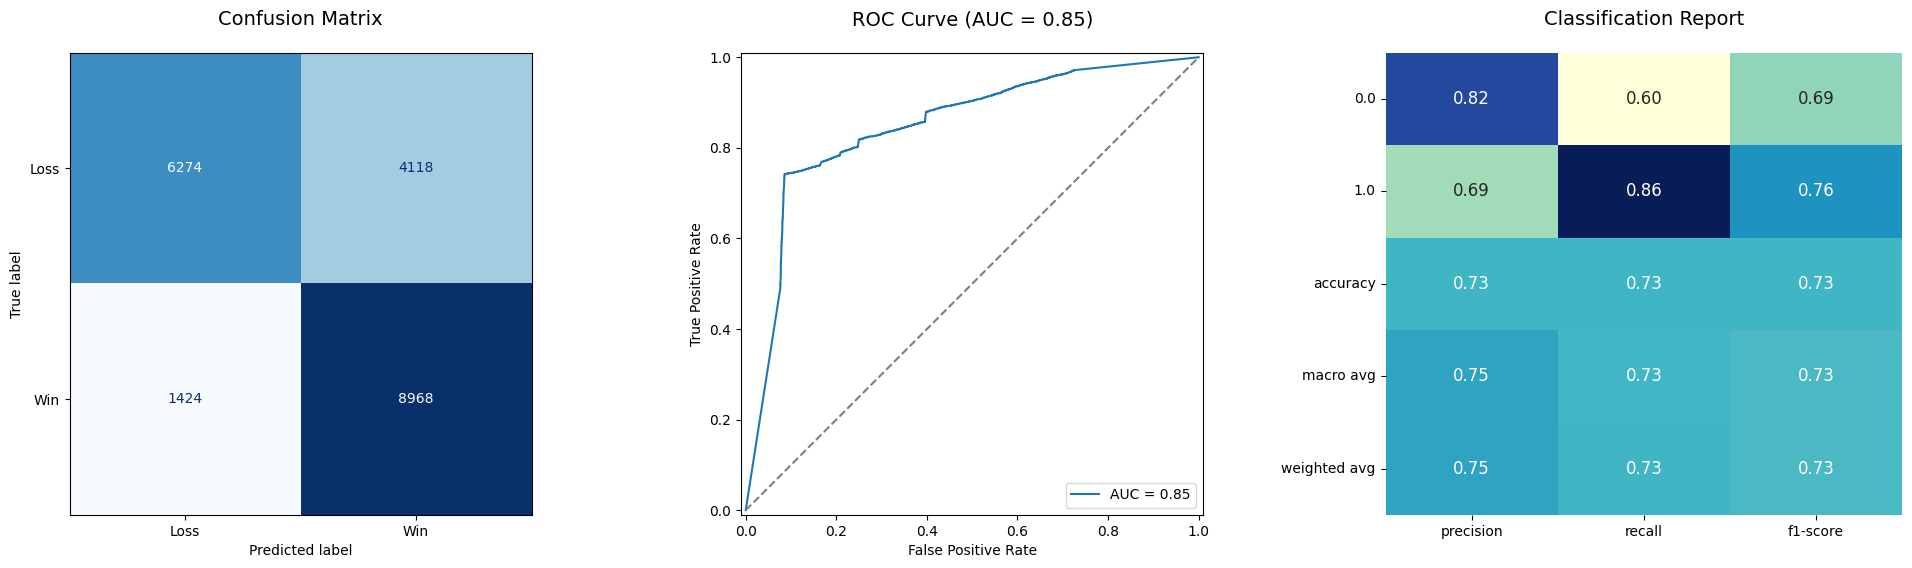

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,880 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,880 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 336)       │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │     10,784 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,577 (189.75 KB)

 Trainable params: 48,577 (189.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8576 - loss: 0.3411 - val_accuracy: 0.8800 - val_loss: 0.2677 - learning_rate: 0.0010
Epoch 2/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9221 - loss: 0.1843 - val_accuracy: 0.9068 - val_loss: 0.2173 - learning_rate: 0.0010
Epoch 3/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9384 - loss: 0.1487 - val_accuracy: 0.8866 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 4/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9514 - loss: 0.1222 - val_accuracy: 0.9225 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 5/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9606 - loss: 0.1022 - val_accuracy: 0.9137 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 6/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9683 - loss: 0.0862 - val_accuracy: 0.9326 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 7/50
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9749 - l

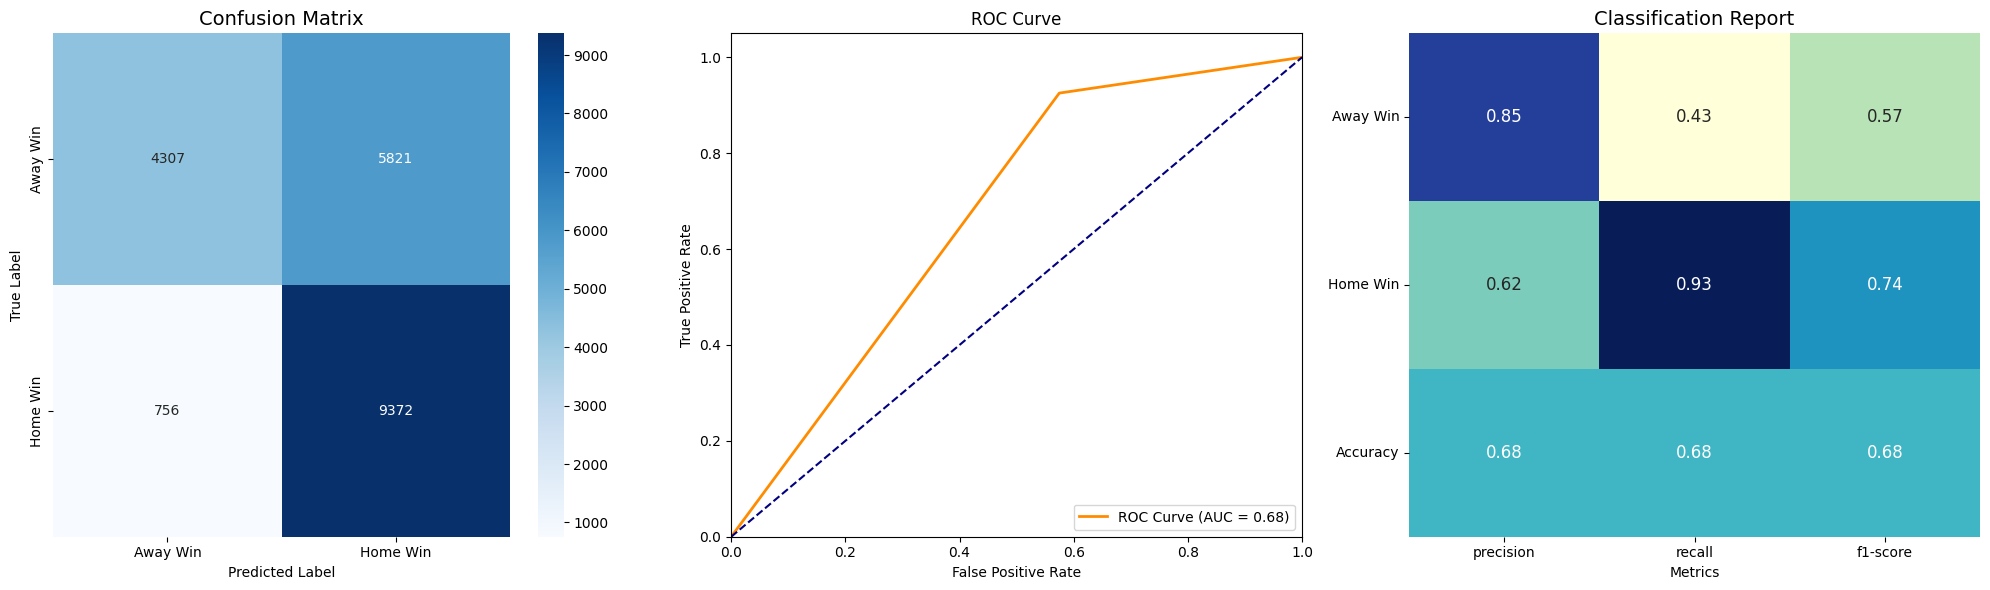

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 234 features

Performing cross-validation...
Cross-validation scores: [0.68368632 0.68437812 0.68197134]
Mean CV accuracy: 0.683 (+/- 0.002)

Training final model...

Model Evaluation:
Accuracy: 0.7195398894154819

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.58      0.67     10128
         1.0       0.67      0.86      0.75     10128

    accuracy                           0.72     20256
   macro avg       0.74      0.72      0.71     20256
weighted avg       0.74      0.72      0.71     20256


Prediction Confidence Analysis:
Mean confidence: 0.866
Min confidence: 0.500
Max confidence: 1.000


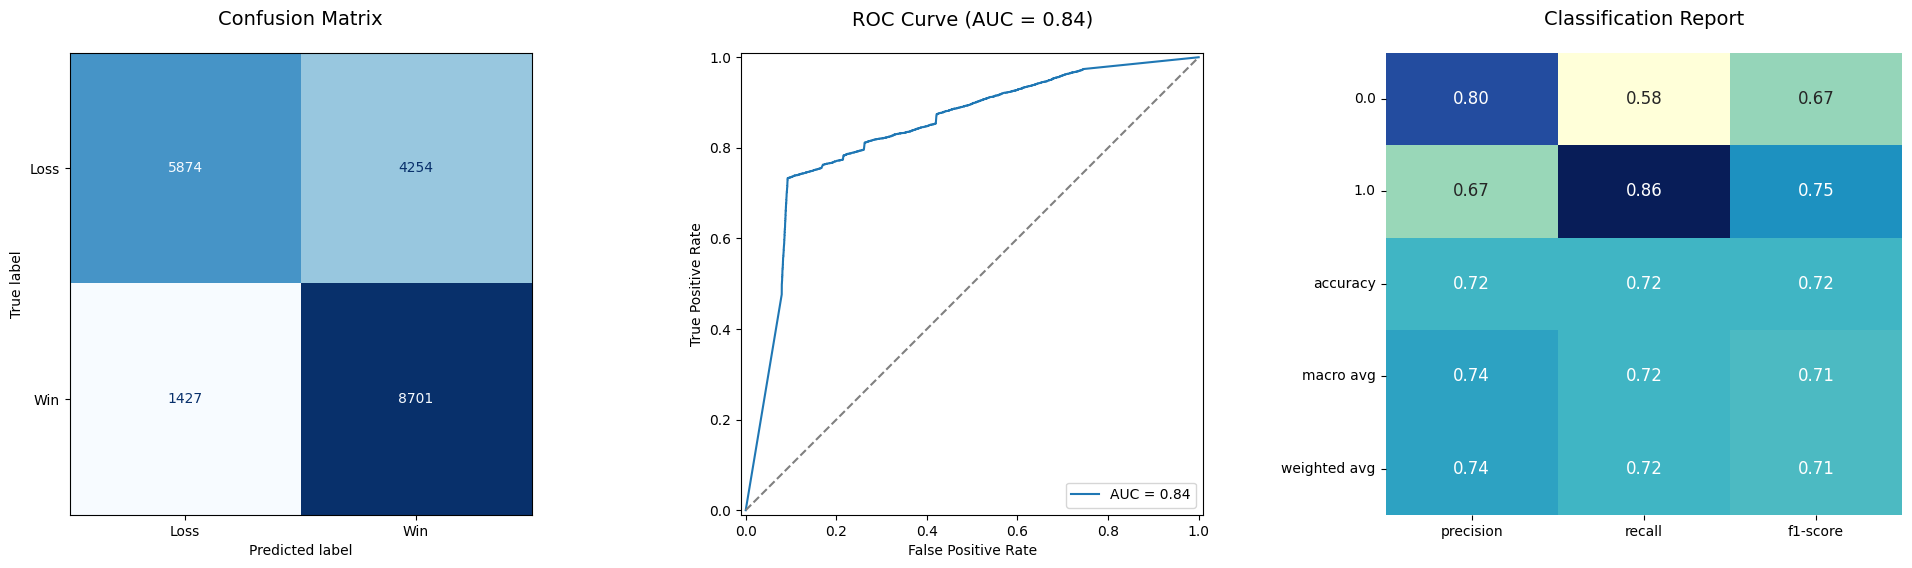

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,880 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,880 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 336)       │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ flatten_11[0][0], │
│                     │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │     10,784 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,577 (189.75 KB)

 Trainable params: 48,577 (189.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8524 - loss: 0.3533 - val_accuracy: 0.8598 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 2/50
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9115 - loss: 0.2073 - val_accuracy: 0.9082 - val_loss: 0.2140 - learning_rate: 0.0010
Epoch 3/50
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9309 - loss: 0.1670 - val_accuracy: 0.8965 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 4/50
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9447 - loss: 0.1399 - val_accuracy: 0.9113 - val_loss: 0.2155 - learning_rate: 0.0010
Epoch 5/50
2506/2510 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1194
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9542 - loss: 0.1194 - val_accuracy: 0.9074 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 6/50
2510/2510 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9654 - lo

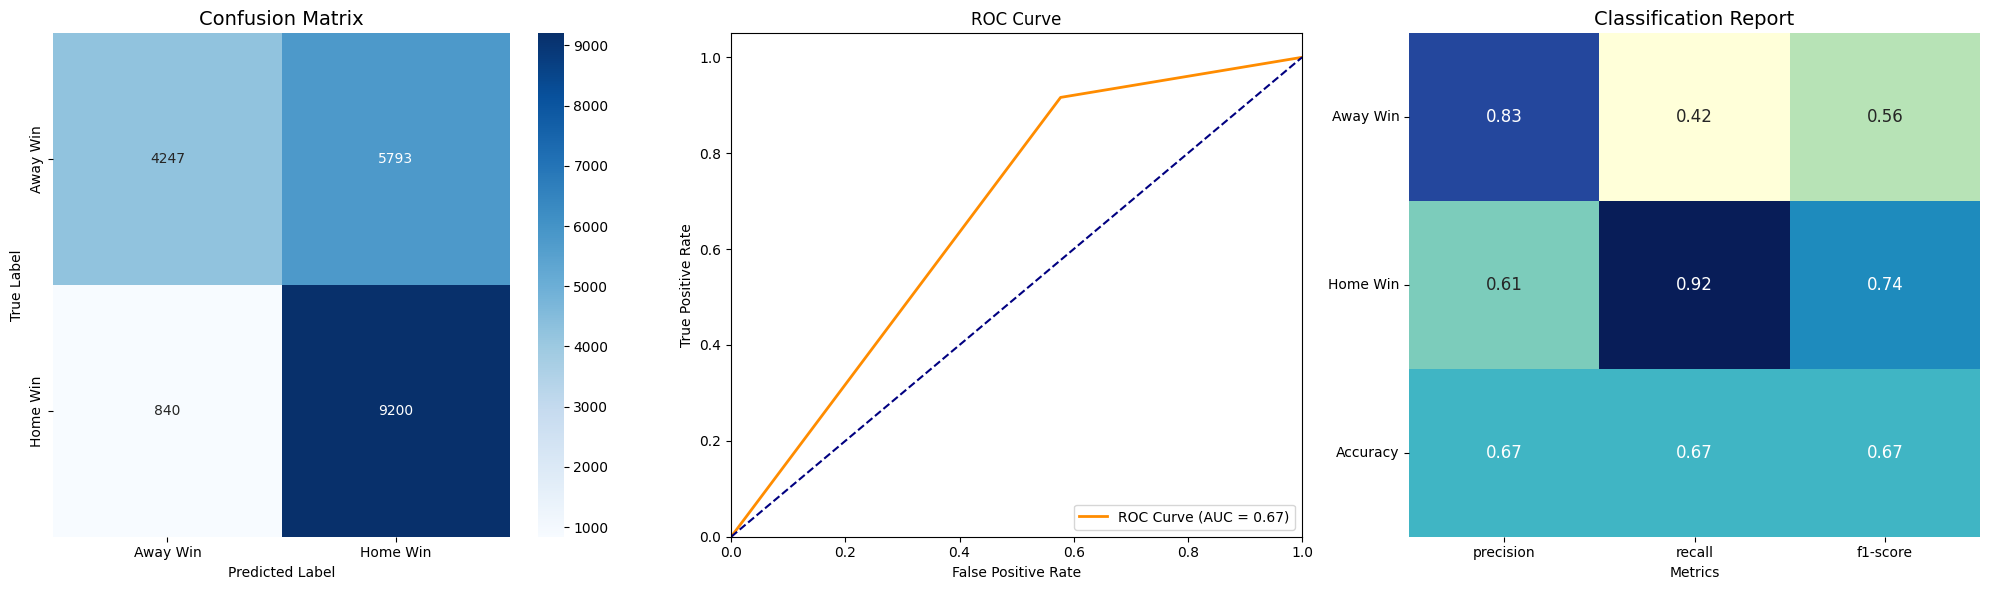

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 219 features

Performing cross-validation...
Cross-validation scores: [0.68422232 0.68112207 0.68340057]
Mean CV accuracy: 0.683 (+/- 0.003)

Training final model...

Model Evaluation:
Accuracy: 0.7182270916334661

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.59      0.68     10040
         1.0       0.67      0.85      0.75     10040

    accuracy                           0.72     20080
   macro avg       0.73      0.72      0.71     20080
weighted avg       0.73      0.72      0.71     20080


Prediction Confidence Analysis:
Mean confidence: 0.865
Min confidence: 0.500
Max confidence: 1.000


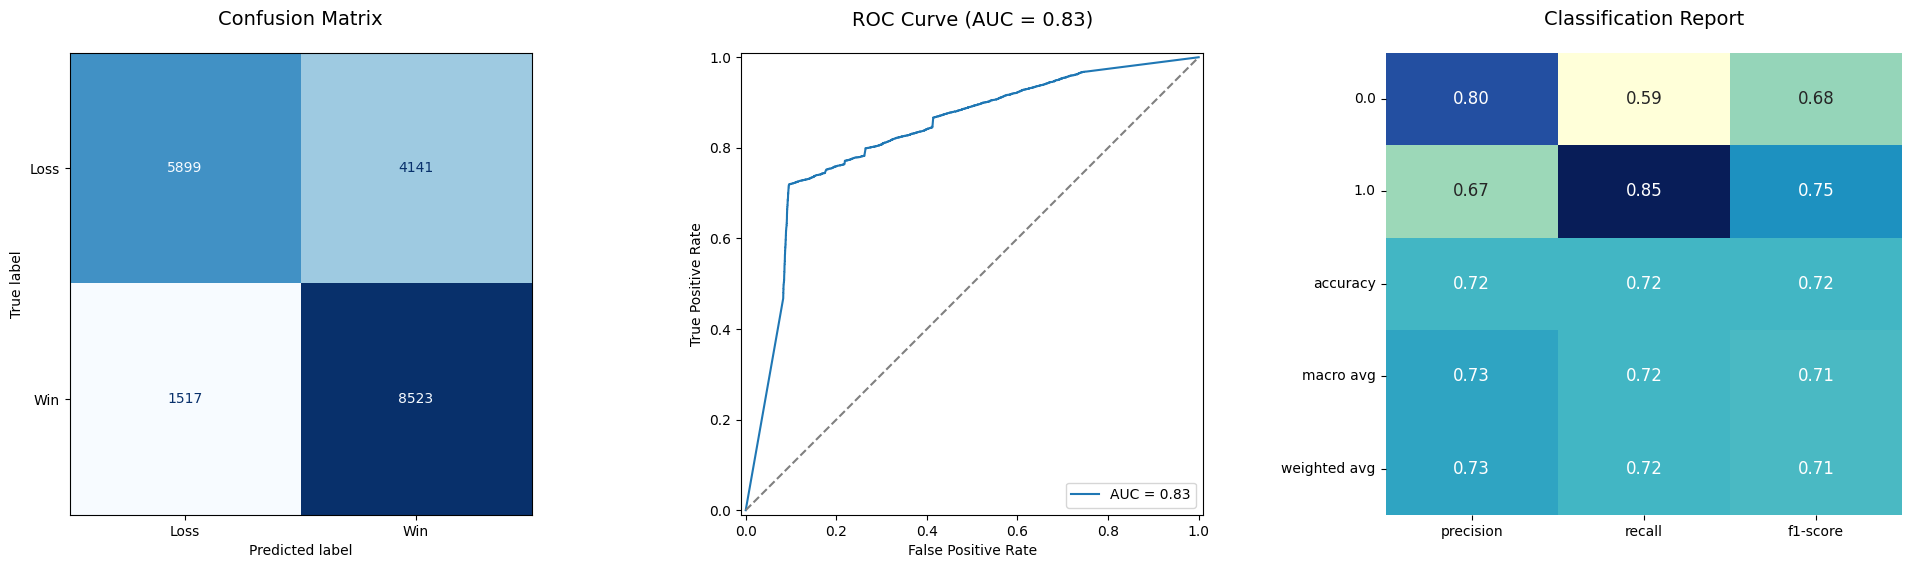

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,520 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,520 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 336)       │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │     10,784 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         33 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,857 (194.75 KB)

 Trainable params: 49,857 (194.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8431 - loss: 0.3541 - val_accuracy: 0.8706 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 2/50
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9174 - loss: 0.1923 - val_accuracy: 0.8937 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 3/50
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9357 - loss: 0.1557 - val_accuracy: 0.9234 - val_loss: 0.1900 - learning_rate: 0.0010
Epoch 4/50
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9496 - loss: 0.1272 - val_accuracy: 0.9109 - val_loss: 0.2155 - learning_rate: 0.0010
Epoch 5/50
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9597 - loss: 0.1072 - val_accuracy: 0.9218 - val_loss: 0.1960 - learning_rate: 0.0010
Epoch 6/50
2324/2346 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9664 - loss: 0.0915
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9664 - l

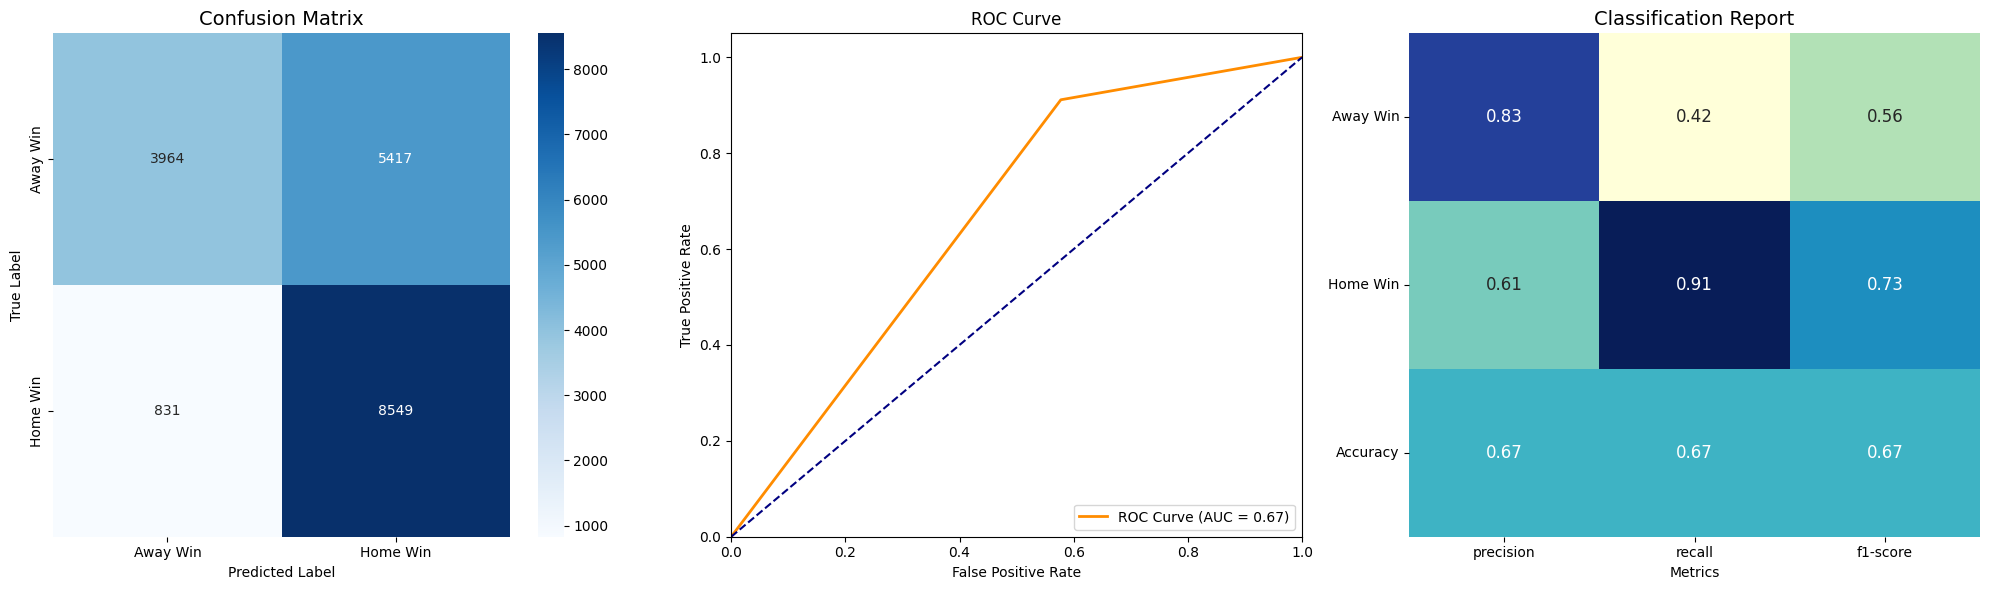

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 228 features

Performing cross-validation...
Cross-validation scores: [0.6790997  0.67782042 0.68156559]
Mean CV accuracy: 0.679 (+/- 0.003)

Training final model...

Model Evaluation:
Accuracy: 0.7189382229092266

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.59      0.68      9381
         1.0       0.67      0.85      0.75      9380

    accuracy                           0.72     18761
   macro avg       0.74      0.72      0.71     18761
weighted avg       0.74      0.72      0.71     18761


Prediction Confidence Analysis:
Mean confidence: 0.862
Min confidence: 0.500
Max confidence: 1.000


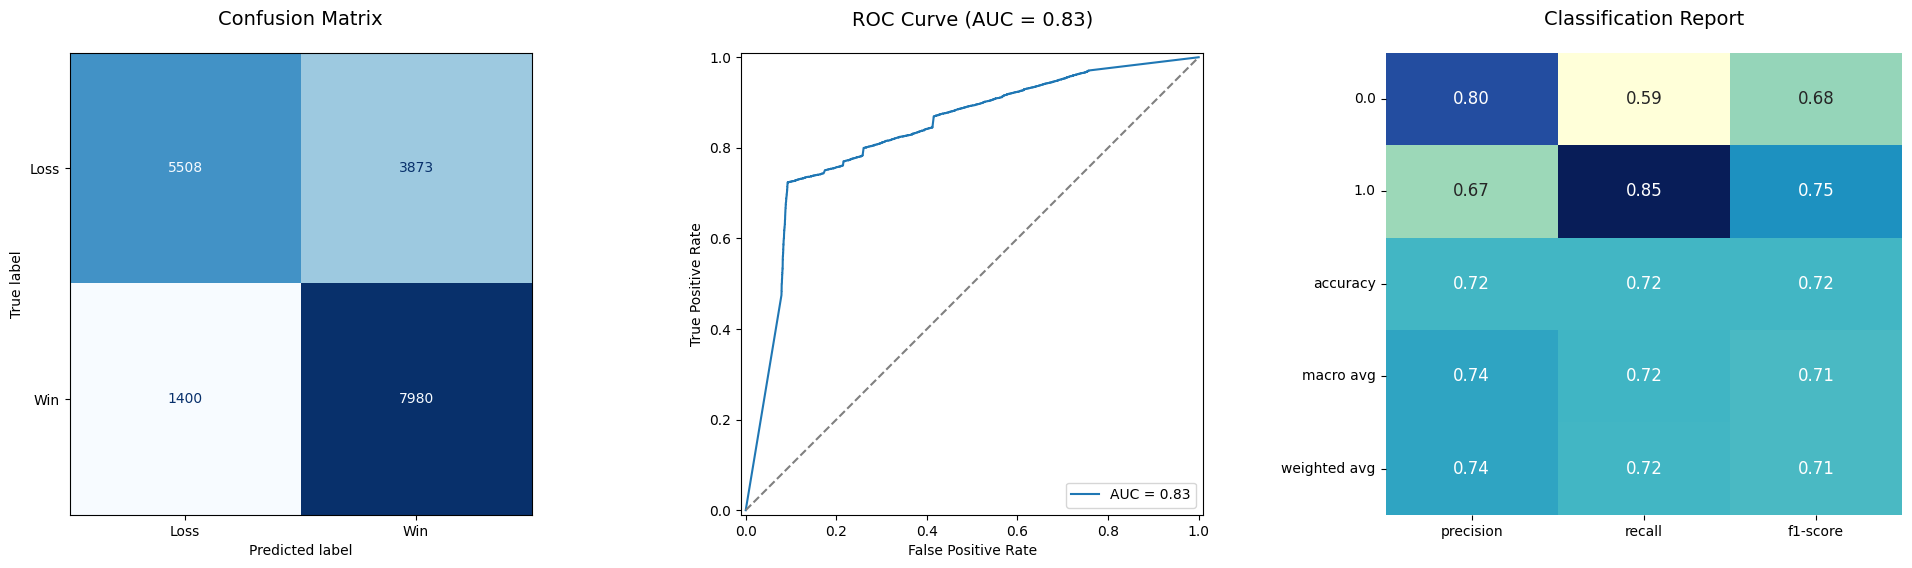

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     20,256 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     20,256 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 336)       │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0], │
│                     │                   │            │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │     10,784 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         33 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8531 - loss: 0.3603 - val_accuracy: 0.8336 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 2/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9115 - loss: 0.2049 - val_accuracy: 0.8620 - val_loss: 0.2989 - learning_rate: 0.0010
Epoch 3/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9317 - loss: 0.1646 - val_accuracy: 0.9170 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 4/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9469 - loss: 0.1369 - val_accuracy: 0.9006 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 5/50
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9545 - loss: 0.1179 - val_accuracy: 0.9168 - val_loss: 0.2109 - learning_rate: 0.0010
Epoch 6/50
2306/2325 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9623 - loss: 0.1007
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9623 - lo

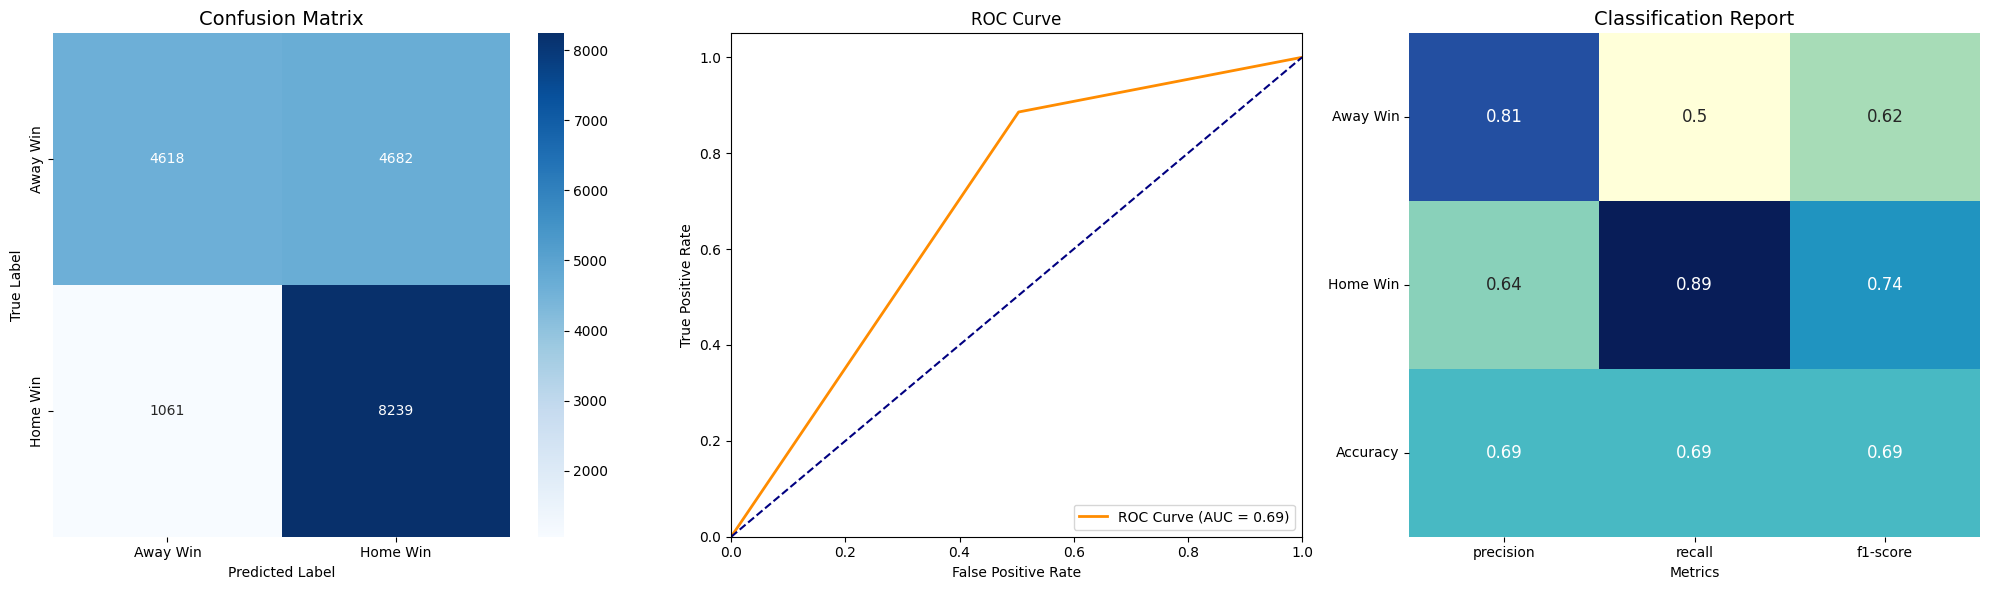

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 222 features

Performing cross-validation...
Cross-validation scores: [0.67608871 0.67389814 0.67055123]
Mean CV accuracy: 0.674 (+/- 0.005)

Training final model...

Model Evaluation:
Accuracy: 0.7143010752688173

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.59      0.67      9300
         1.0       0.67      0.84      0.75      9300

    accuracy                           0.71     18600
   macro avg       0.73      0.71      0.71     18600
weighted avg       0.73      0.71      0.71     18600


Prediction Confidence Analysis:
Mean confidence: 0.861
Min confidence: 0.500
Max confidence: 1.000


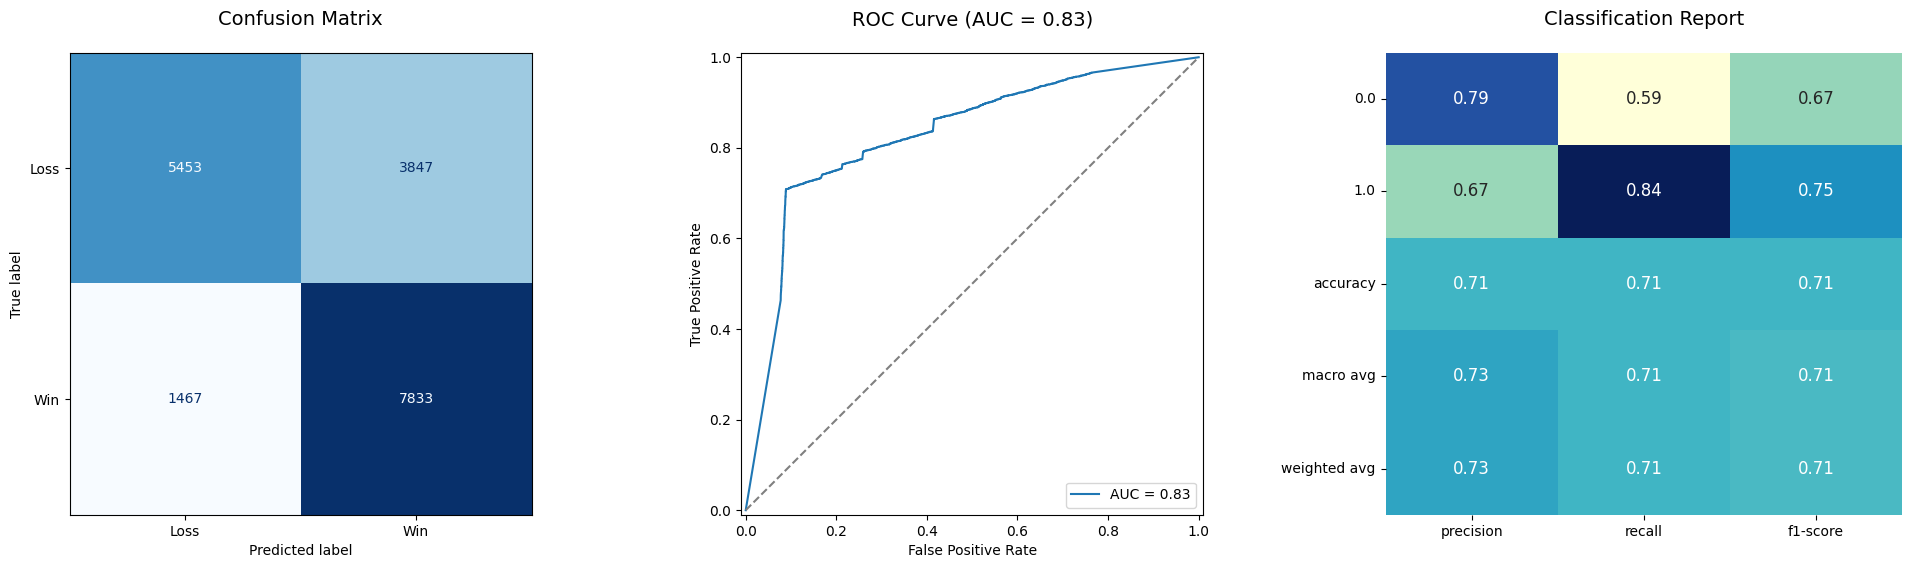

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     20,896 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     20,896 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 336)       │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0], │
│                     │                   │            │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │     10,784 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         33 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,609 (205.50 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8556 - loss: 0.3514 - val_accuracy: 0.8971 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 2/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9152 - loss: 0.1965 - val_accuracy: 0.8650 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 3/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9356 - loss: 0.1548 - val_accuracy: 0.8972 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 4/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9498 - loss: 0.1282 - val_accuracy: 0.8930 - val_loss: 0.2550 - learning_rate: 0.0010
Epoch 5/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9619 - loss: 0.1060 - val_accuracy: 0.8957 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 6/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9673 - loss: 0.0903 - val_accuracy: 0.9160 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 7/50
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9739 - 

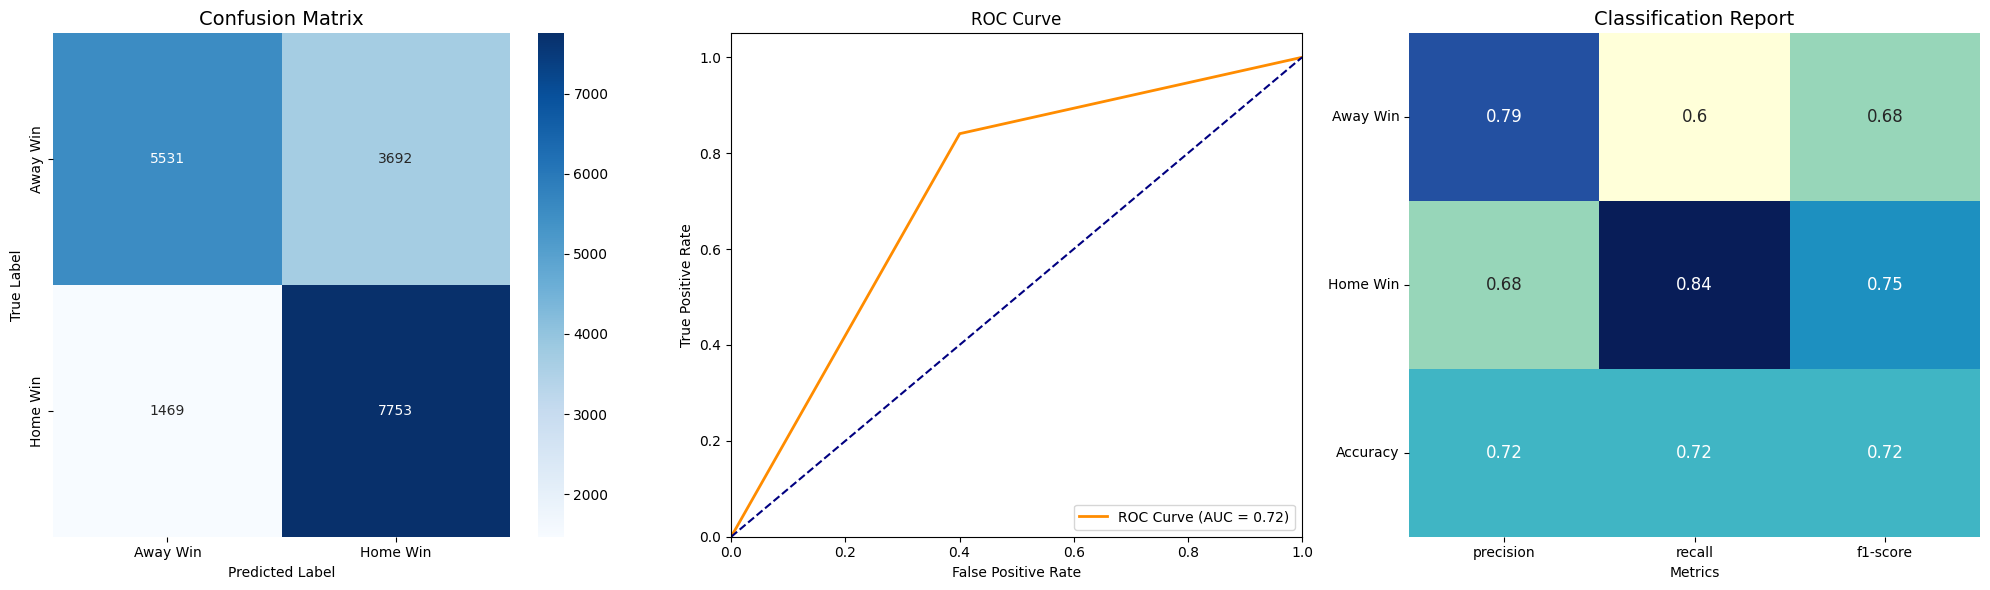

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 240 features

Performing cross-validation...
Cross-validation scores: [0.66539259 0.66868621 0.66697841]
Mean CV accuracy: 0.667 (+/- 0.003)

Training final model...

Model Evaluation:
Accuracy: 0.7081051775548929

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.58      0.67      9223
         1.0       0.67      0.83      0.74      9222

    accuracy                           0.71     18445
   macro avg       0.72      0.71      0.70     18445
weighted avg       0.72      0.71      0.70     18445


Prediction Confidence Analysis:
Mean confidence: 0.853
Min confidence: 0.500
Max confidence: 1.000


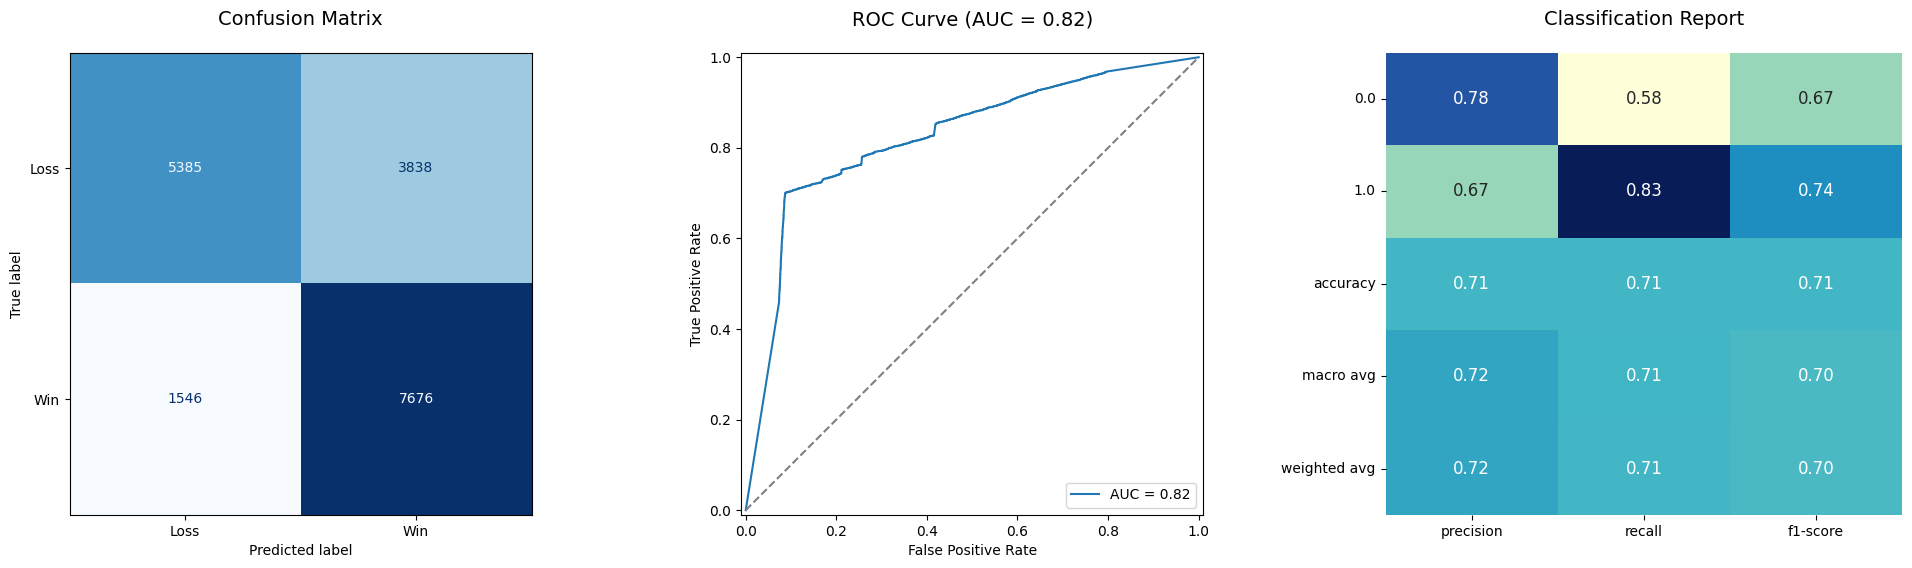

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     20,736 │ input_layer_28[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     20,736 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 336)       │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │     10,784 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │         33 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,289 (204.25 KB)

 Trainable params: 52,289 (204.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8295 - loss: 0.3728 - val_accuracy: 0.8231 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 2/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9073 - loss: 0.2150 - val_accuracy: 0.8636 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 3/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9288 - loss: 0.1708 - val_accuracy: 0.9015 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 4/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9421 - loss: 0.1438 - val_accuracy: 0.9014 - val_loss: 0.2304 - learning_rate: 0.0010
Epoch 5/50
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9522 - loss: 0.1227 - val_accuracy: 0.9083 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 6/50
2484/2494 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1045
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9603 - 

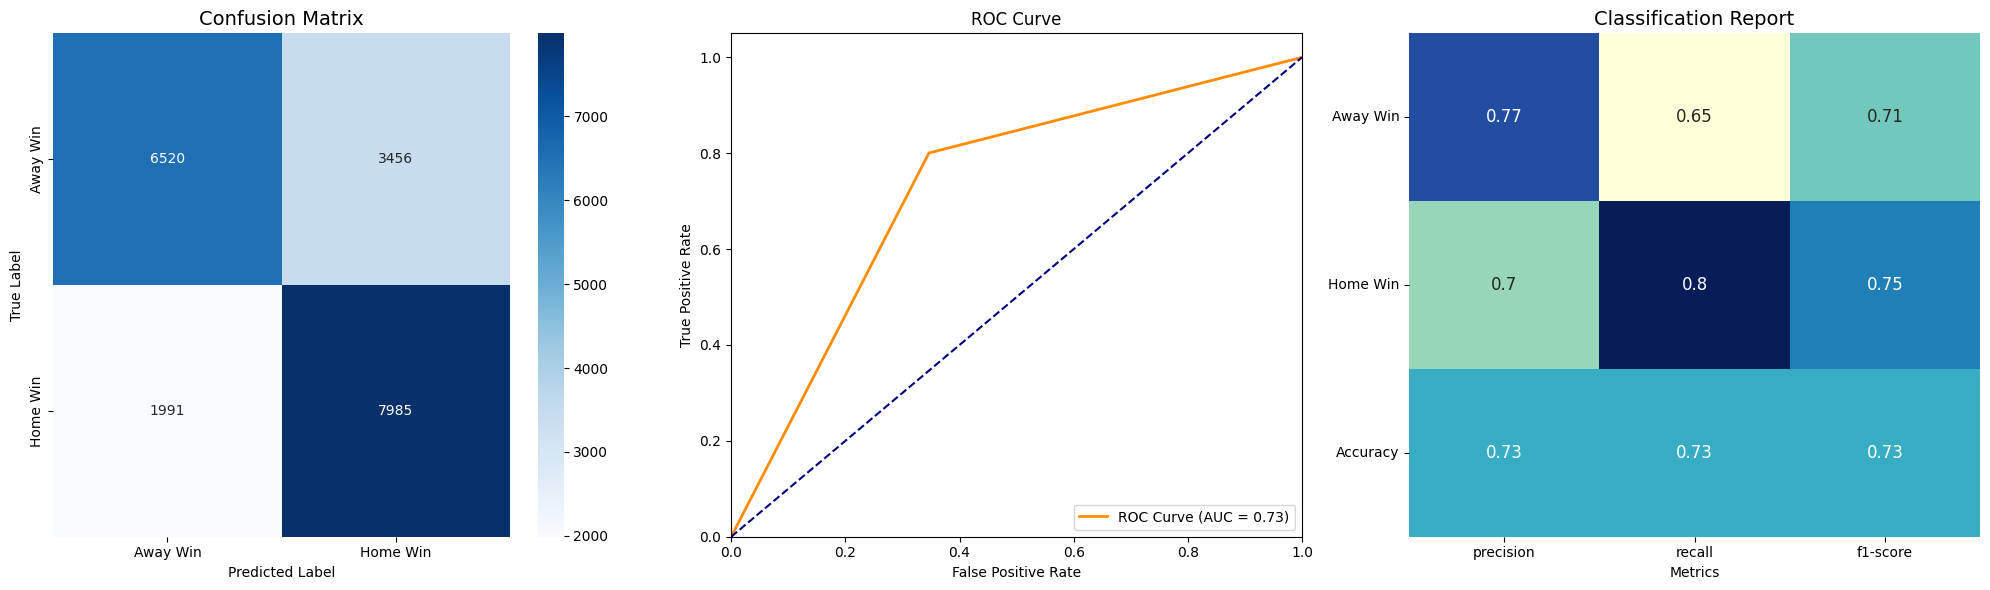

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 235 features

Performing cross-validation...
Cross-validation scores: [0.65416134 0.65215593 0.65305816]
Mean CV accuracy: 0.653 (+/- 0.002)

Training final model...

Model Evaluation:
Accuracy: 0.6931134723336007

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65      9976
         1.0       0.65      0.82      0.73      9976

    accuracy                           0.69     19952
   macro avg       0.71      0.69      0.69     19952
weighted avg       0.71      0.69      0.69     19952


Prediction Confidence Analysis:
Mean confidence: 0.847
Min confidence: 0.500
Max confidence: 1.000


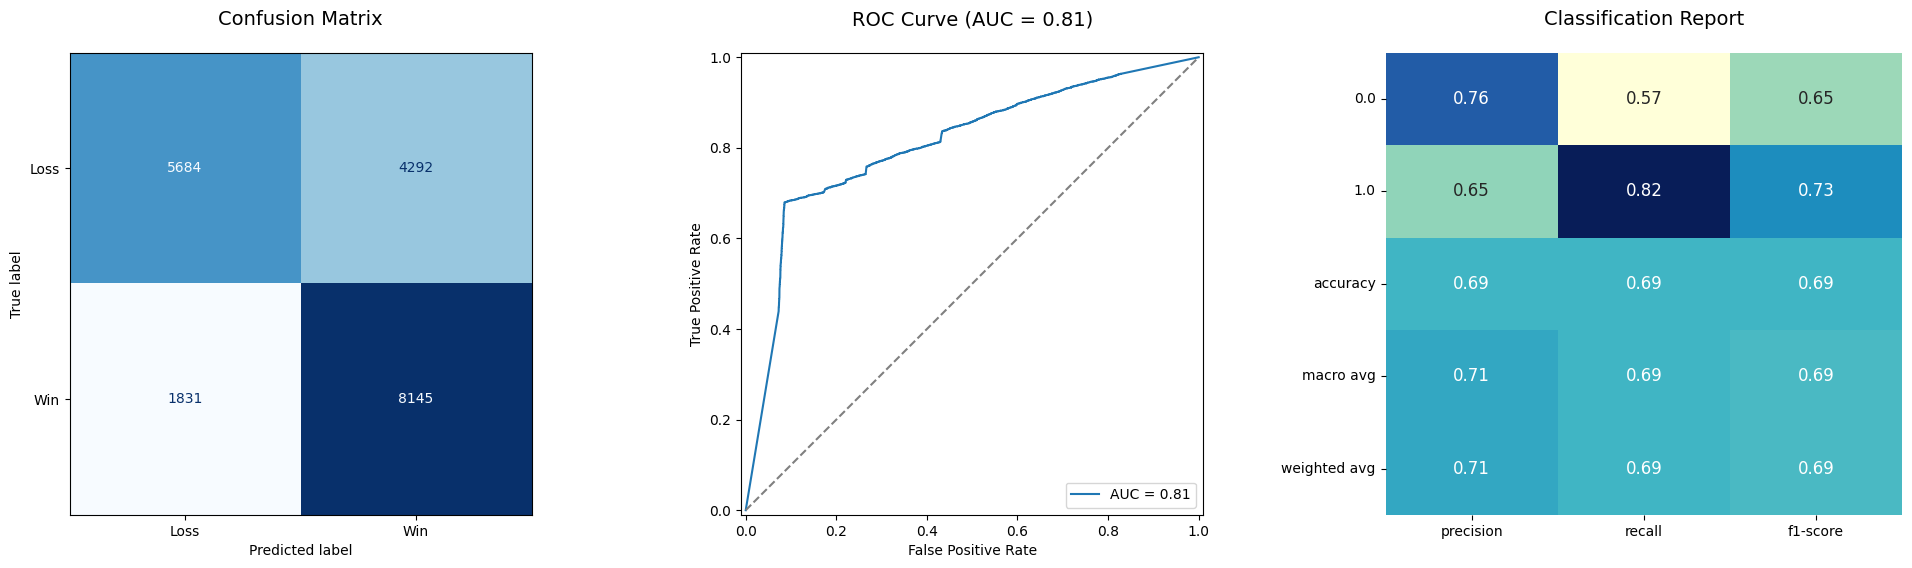

In [57]:
year_on_year_models = generate_models(year_on_year_datasets)

In [58]:
save_generated_models(year_on_year_models, year_on_year_datasets)

{2007: {'LAL': ['Sasha Vujacic', 'Smush Parker', 'Luke Walton', 'Maurice Evans', 'Lamar Odom', 'Ronny Turiaf', 'Vladimir Radmanovic', 'Jordan Farmar', 'Brian Cook', 'Kobe Bryant', 'Aaron McKie', 'Kwame Brown', 'Andrew Bynum', 'Shammond Williams'], 'PHO': ['Boris Diaw', 'Steve Nash', 'Jalen Rose', 'Raja Bell', 'Leandro Barbosa', 'Pat Burke', 'James Jones', 'Shawn Marion', 'Marcus Banks', "Amar'e Stoudemire", 'Jumaine Jones', 'Sean Marks', 'Kurt Thomas', 'Eric Piatkowski'], 'LAC': ['Sam Cassell', 'Paul Davis', 'Aaron Williams', 'Tim Thomas', 'Yaroslav Korolev', 'Doug Christie', 'Shaun Livingston', 'Corey Maggette', 'Cuttino Mobley', 'Chris Kaman', 'James Singleton', 'Alvin Williams', 'Will Conroy', 'Luke Jackson', 'Quinton Ross', 'Jason Hart', 'Daniel Ewing', 'Elton Brand'], 'UTA': ['Andrei Kirilenko', 'Roger Powell', 'Carlos Boozer', 'Lou Amundson', 'Dee Brown', 'Mehmet Okur', 'Rafael Araujo', 'Ronnie Brewer', 'Derek Fisher', 'Matt Harpring', 'Deron Williams', 'Gordan Giricek', 'C.J. Mi